In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from tqdm.notebook import tqdm, trange
import pickle as pkl

%load_ext autoreload
%autoreload 2

from utils import *
from bs_helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Erstellt August 2020
# (c) mha

def create_sea_ships(seed=None):
    'Creates a sea with random ships on it'
    rng = random.Random(seed)
    sea = np.zeros((10,10))
    ships = np.zeros((10,10,4)) # extra information which kind of ship is where
    for k, l in enumerate([5,4,3,2]): # Länge
        n = 6-l # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = rng.random() < 0.5
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(1,0,2)
                px = rng.randint(0, 10-l)
                py = rng.randint(0, 9)
                if sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                ships[px:px+l, py, k] = 1
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(1,0,2)
                break
    return sea, ships

def create_detection(seed=None, l=5):
    'Creates a random detected array (for test purposes)'
    rng = random.Random(seed)
    det = np.zeros((10,10))
    px = rng.randint(0, 10-l)
    py = rng.randint(0, 9)
    det[px:px+l, py] = 1
    
    if rng.random() < 0.5: 
        det = det.T
    return det

def visualize(sea, detection):
    'Erstellt eine Veranschaulichung, 0 bzw. 4 sind detektiertes Wasser bzw. Schiff, 1 und 2 sind undetektiert.'
    return sea + sea*detection + 1 - ((1-sea)*detection)

def plot_sea(sea, det, ax=None):
    if ax is None: ax = plt.gca()
    #ax.imshow(visualize(sea, det), vmin=-2, cmap='plasma')
    ax.imshow(visualize(sea, det), vmin=-1, vmax=3.15, cmap='cividis')
    ax.axis('off')

In [10]:
from numba import njit, jit

@njit(cache=True)
def njit_create_sea():
    'Creates a sea with random ships on it'
    sea = np.zeros((10,10))
    for l in [5,4,3,2]: # Länge
        n = 6-l # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = np.random.rand() < 0.5
                if t: sea = sea.T # Transponieren
                px = np.random.randint(0, 11-l)
                py = np.random.randint(0, 10)
                if np.sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                if t: sea = sea.T # Transponieren
                break
    return sea

In [11]:
sea = create_sea(0)
#detection = np.zeros((10,10))
#detection[4, 0:5] = 1.
det = create_detection(l=5, seed=1)
###detected = detect(sea, det)

plt.imshow(sea*255)
plot_sea(sea, det)

NameError: name 'create_sea' is not defined

In [12]:
#ships = create_sea_ships()[1]
plt.imshow(ships[:,:,3])
plt.imshow(ships.sum(-1))

NameError: name 'ships' is not defined

### Modell trainieren

In [13]:
def encode_x(sea, det):
    'Encodes the visible information to an input to the neural network'
    return np.stack([(1-sea)*det, (1-det), sea*det], -1)
    

def batchgen(size=50):
    while True:
        xs, ys1, ys2 = [], [], []
        for _ in range(size):
            sea, ships = create_sea_ships()
            r = np.random.rand()
            if r < 0.25:
                det = np.random.rand(10,10) < np.random.rand()
            elif r < 0.5:
                det = np.random.rand(10,10) < 1/30*np.random.rand()
            elif r < 0.75:
                det = np.random.rand(10,10) < 1/6*np.random.rand()
            else:
                det = np.random.rand(10,10) < 0.5*np.random.rand()
            x = encode_x(sea, det)
            xs.append(x)
            ys1.append(sea.reshape((10,10,1)))
            ys2.append(ships)
        yield np.array(xs), np.asarray(ys1), np.asarray(ys2)
        

In [14]:
import torch
from torch import nn
from utils import *

In [15]:
relu = torch.nn.ReLU()
sigmoid = torch.nn.Sigmoid()
softmax = torch.nn.Softmax2d()

class bship_nnet(nn.Module):
    def __init__(self, n=32):
        'BattleShip CNN. More than 1 blocks didnt make a difference.'
        super().__init__()
        self.conv1 = nn.Conv2d(3, n, 5, padding=2) # 10x10
        self.down1 = ResBlockDown(n, 2*n)  # 5x5
        self.down2 = ResBlockDown(2*n, 4*n) # 3x3
        self.down3 = ResBlockDown(4*n, 8*n) # 2x2
        self.resblock4 = ResBlock(8*n, 8*n)
        self.resblock3 = ResBlock(4*n, 4*n)
        self.resblock2 = ResBlock(2*n, 2*n)
        self.resblock1 = ResBlock(n, n)
        self.up3 = ResBlockUp(8*n, 4*n)
        self.up2 = ResBlockUp(4*n, 2*n)
        self.up1 = ResBlockUp(2*n, n)
        self.conv_m1 = nn.Conv2d(n, 1, 3, padding=1)
        self.conv_m1_ships = nn.Conv2d(n, 4, 3, padding=1)
        
    def forward(self, x):
        # NHWC zu NCHW
        x = x.permute([0, 3, 1, 2])
        
        x = relu(self.conv1(x))
        #print(x.shape)
        xskip1 = x
        x = expandtoeven(x)
        x = self.down1(x)
        #print(x.shape)
        xskip2 = x
        x = expandtoeven(x)
        x = self.down2(x)
        #print(x.shape)
        xskip3 = x
        x = expandtoeven(x)
        x = self.down3(x)
        #print(x.shape)

        x = self.resblock4(x)
        #print(x.shape)
        
        x = self.up3(x)
        x = addskip(x, xskip3)
        x = self.resblock3(x)
        #print(x.shape)
        x = self.up2(x)
        x = addskip(x, xskip2)
        x = self.resblock2(x)
        #print(x.shape)
        x = self.up1(x)
        #print(x.shape, xskip1.shape)
        x = addskip(x, xskip1)
        x = self.resblock1(x)
        #print(x.shape)
        
        y = x
        y = self.conv_m1_ships(y)
        #y = softmax(y)
        y = y.permute([0, 2, 3, 1])
        self.res_ships = y
        
        y = x
        y = self.conv_m1(y)
        y = sigmoid(y)
        
        # NCHW zu NHWC
        y = y.permute([0, 2, 3, 1])
        return y
    
    def predict(self, x):
        'Takes a numpy array and give out one, i. e. 10x10 -> 10x10'
        x = np2t(x[None,:])
        y = self(x)
        return t2np(y[0,:,:,0])
    
    
    
def augment(x, y):
    r = np.random.rand
    if r()<0.5:
        x, y = x.flip(1), y.flip(1)
    if r()<0.5:
        x, y = x.flip(2), y.flip(2)
    if r()<0.5:
        x, y = x.transpose(1,2), y.transpose(1,2)
    return x, y


net = bship_nnet().cuda();
optimizer = torch.optim.Adam(lr=1e-3, params=net.parameters())
net.losses = []
net.iters = 0

teacher = bship_nnet().cuda()
teacher.load_state_dict(net.state_dict());
teacher.eval();

In [16]:
with open('data/battleships_unet2.dat', 'rb') as f:
    net.load_state_dict(torch.load(f))

In [99]:
optimizer = torch.optim.Adam(lr=1e-5, params=net.parameters())
tau = 0.99
bg = batchgen(512)

  0%|          | 0/400000 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


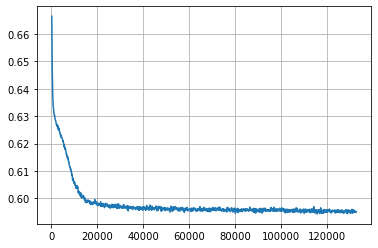

1.4841827154159546
0.0022049599717138334


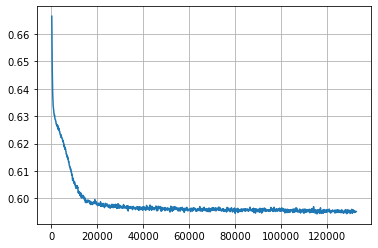

1.499693512916565
0.0021917021493936773


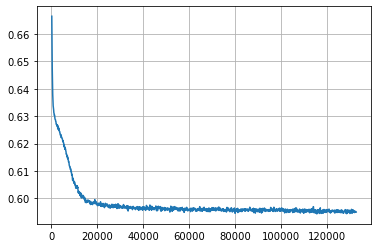

1.47972571849823
0.002066812898447097


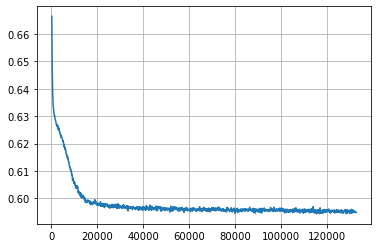

1.4574097394943237
0.0021507983495394002


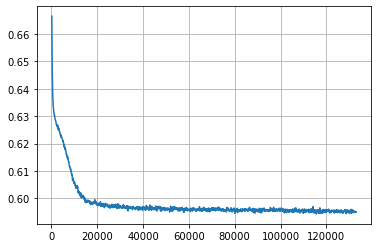

1.487322449684143
0.002222418135461339


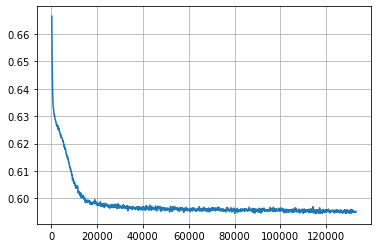

1.4676378965377808
0.0021260991066810674


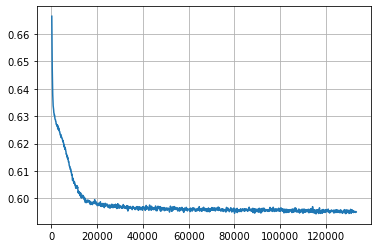

1.4573043584823608
0.0023083047537511446


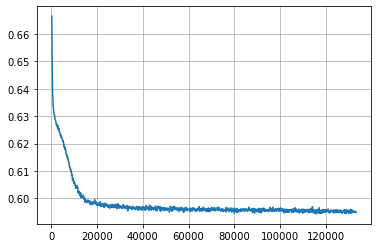

1.4829144477844238
0.0020944119250816584


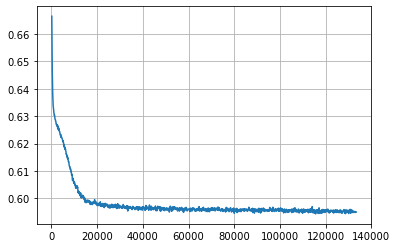

1.4590610265731812
0.002236087274432066


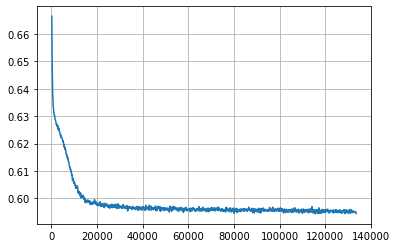

1.4734138250350952
0.002244189659541007


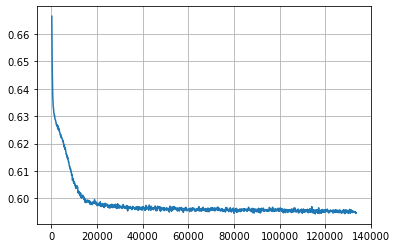

1.4706510305404663
0.0021453160771125112


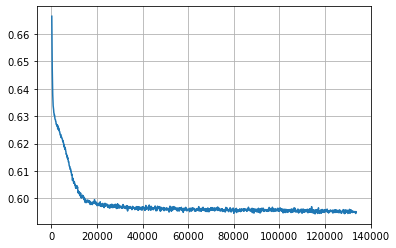

1.480123519897461
0.0023393538169329984


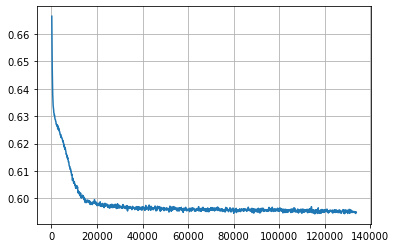

1.4802448749542236
0.002210959870626539


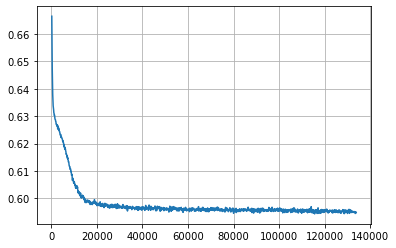

1.4743338823318481
0.0021557394796400333


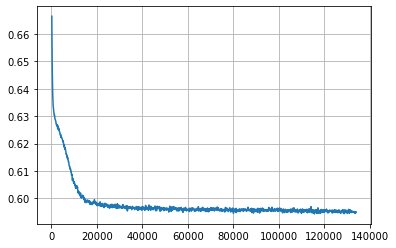

1.4907716512680054
0.002174524060646945


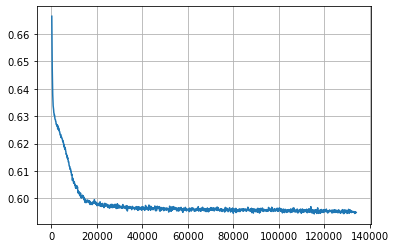

1.490964651107788
0.002227703225435107


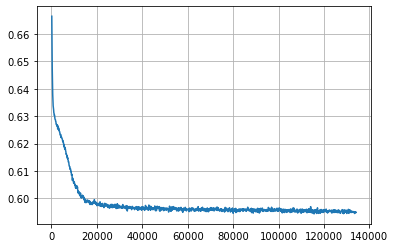

1.4834327697753906
0.0021451435256312833


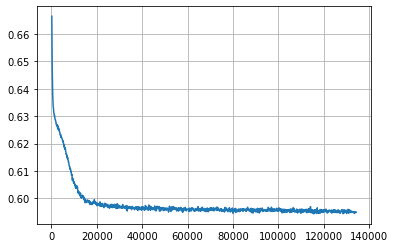

1.4745705127716064
0.0021550966887662073


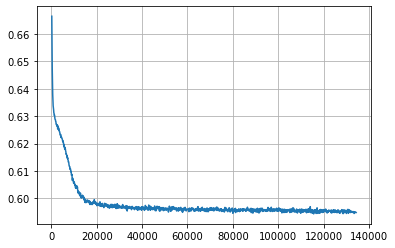

1.48064124584198
0.002217233992596448


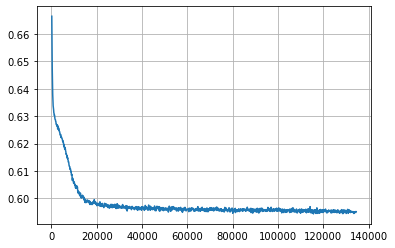

1.4830564260482788
0.0022305326573405183


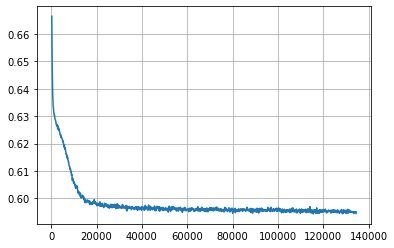

1.4685146808624268
0.002060225103959965


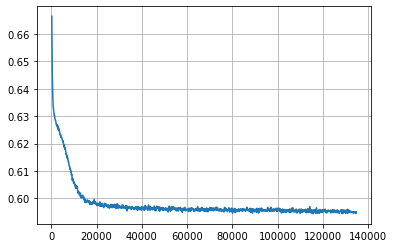

1.4682258367538452
0.0022086728604335804


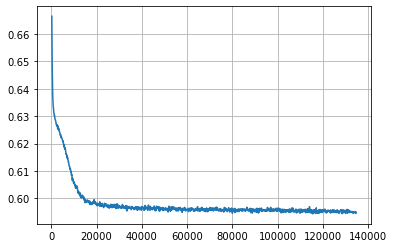

1.466585397720337
0.0021856234484221204


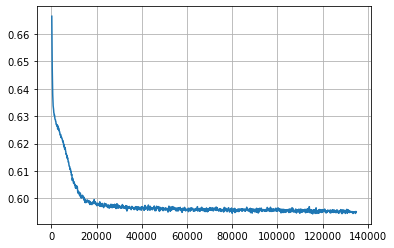

1.4599140882492065
0.002131636992598942


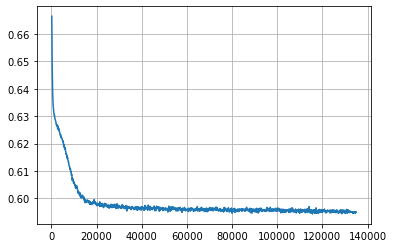

1.4652575254440308
0.00220180238429748


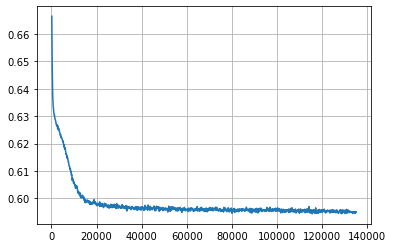

1.4869800806045532
0.0022492852857976687


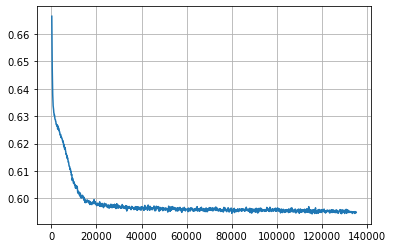

1.5018248558044434
0.0021593492121246526


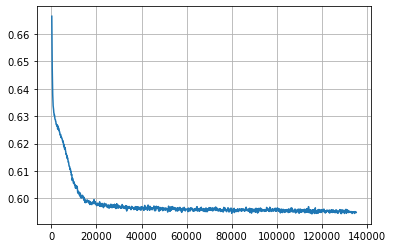

1.453611135482788
0.0020889867183177557


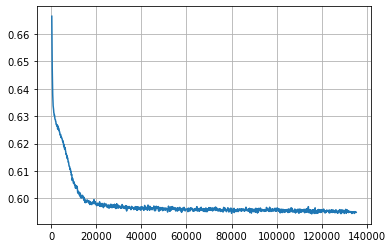

1.473899245262146
0.0023243695812197986


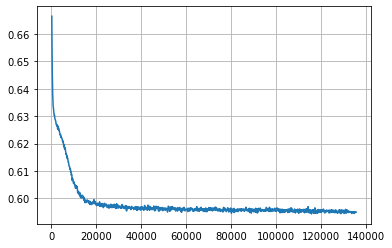

1.4614166021347046
0.0023588293714419707


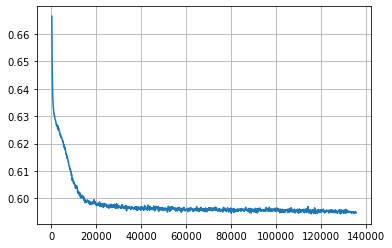

1.506546139717102
0.0022327218670397998


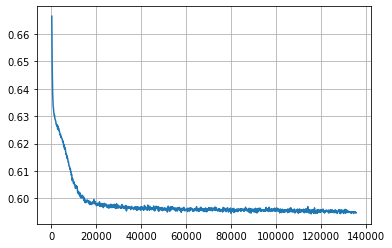

1.4744417667388916
0.0023424515952865477


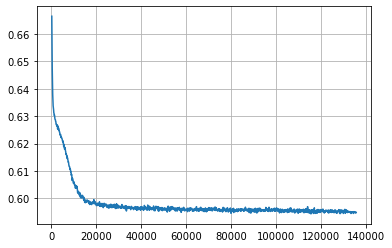

1.4885672330856323
0.0022112354829732796


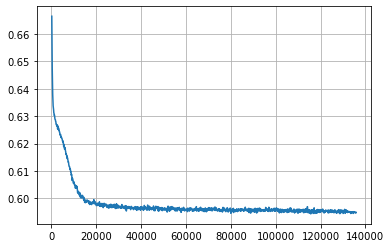

1.4605820178985596
0.002254787566853338


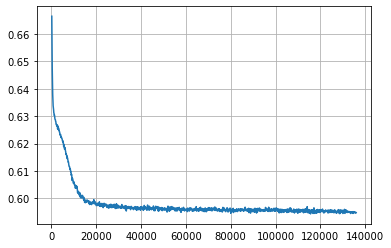

1.4683843851089478
0.0022655035842763026


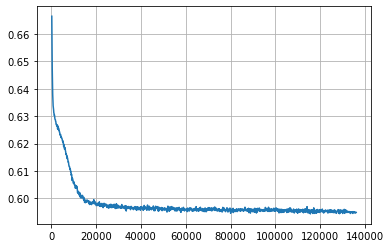

1.4824837446212769
0.0024436015709943604


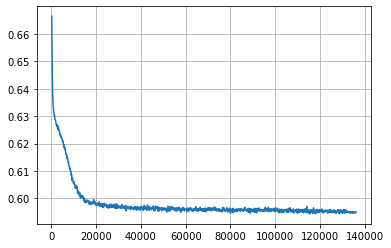

1.4907722473144531
0.0023575903597520664


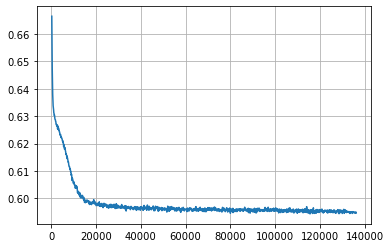

1.482798457145691
0.0023077616333102924


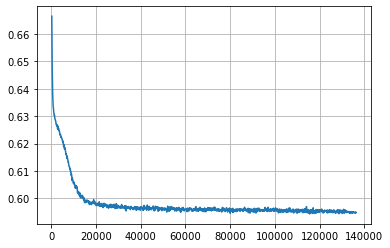

1.4803322553634644
0.0020802071345678995


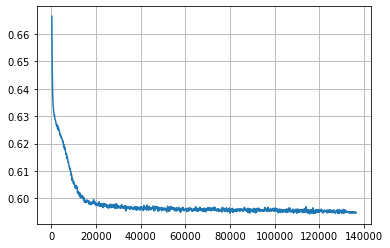

1.5006306171417236
0.0021187769724565443


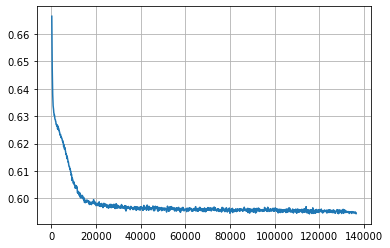

1.495227575302124
0.002186200207179354


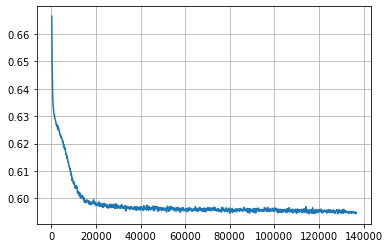

1.4682021141052246
0.0020722938300787065


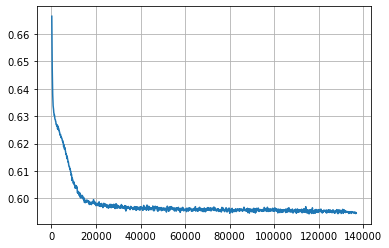

1.4513262510299683
0.0023510479198012037


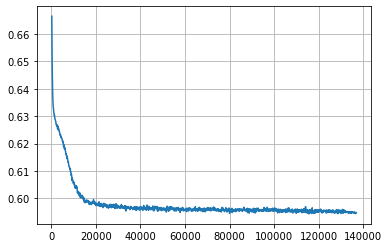

1.4912995100021362
0.002163147417923028


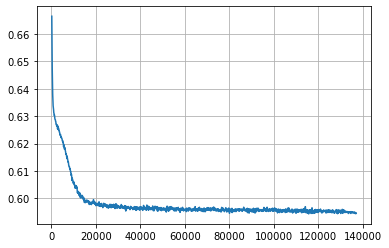

1.4608463048934937
0.002345423263122939


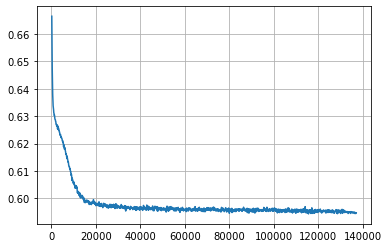

1.4773527383804321
0.0022981702569450134


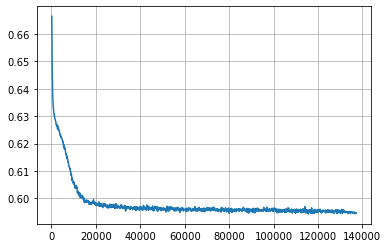

1.4794405698776245
0.002266374840692151


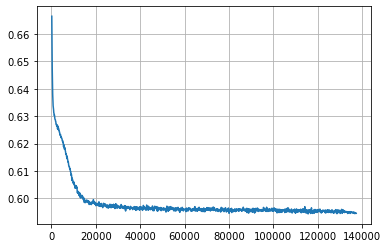

1.468118667602539
0.0022728512429785043


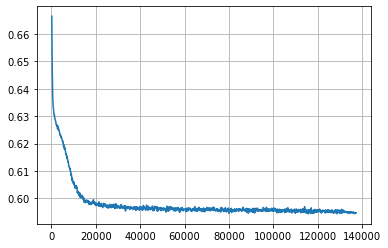

1.4635251760482788
0.0022693679175063153


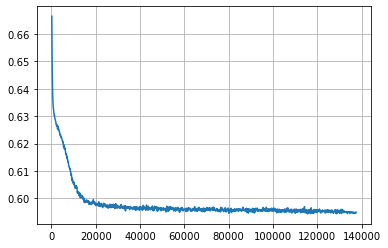

1.4863357543945312
0.0022655976580790594


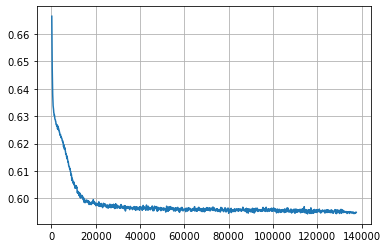

1.465009093284607
0.002210608866007533


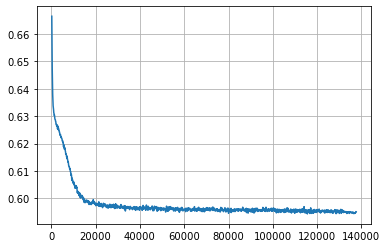

1.4709001779556274
0.002248953801827156


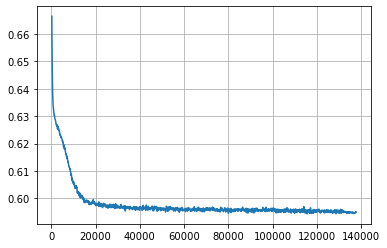

1.4805885553359985
0.002196457348873082


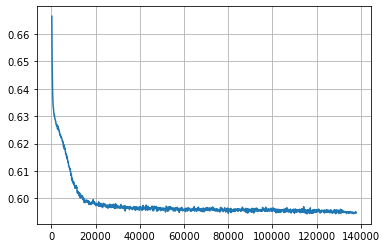

1.4772664308547974
0.0023513259732862936


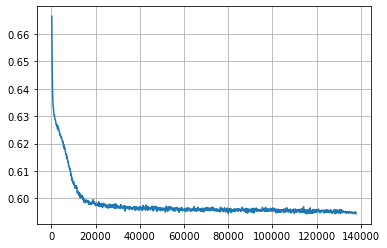

1.4817534685134888
0.002251105398790969


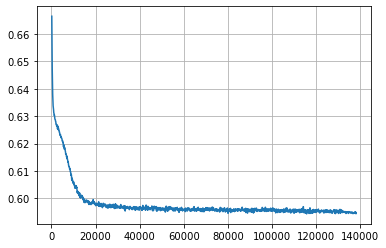

1.472171664237976
0.002167341789445345


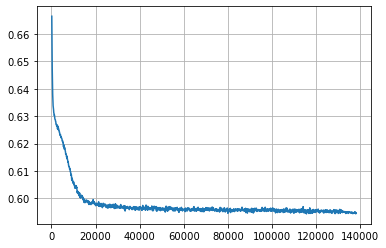

1.4559935331344604
0.0022453369951836066


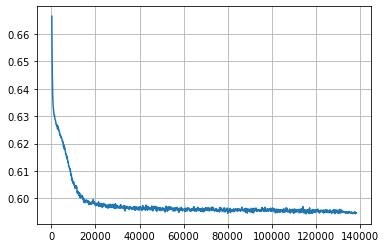

1.4855605363845825
0.0023676932839953226


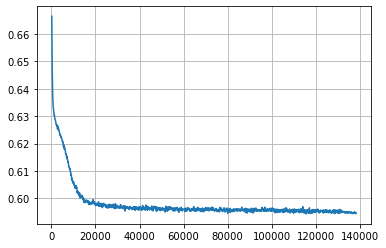

1.4689483642578125
0.002173210831169854


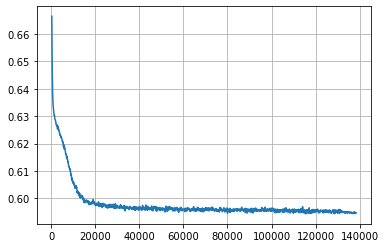

1.468286395072937
0.0023777051773686254


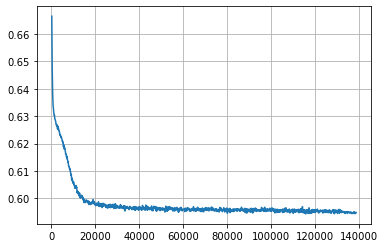

1.4737114906311035
0.002266594094726315


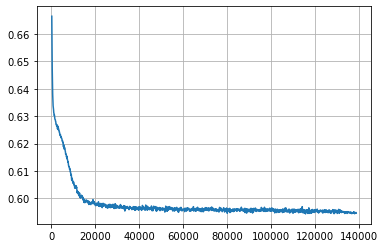

1.4739233255386353
0.002341221991518978


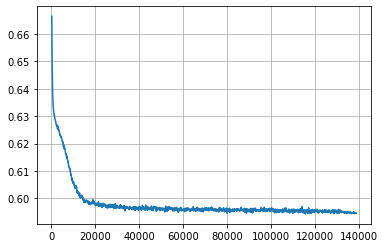

1.466709017753601
0.0022838670740384258


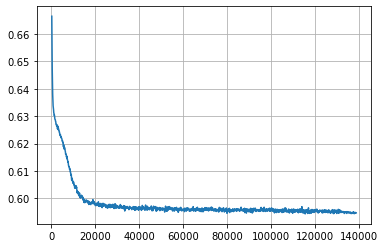

1.4942963123321533
0.0022091442373130122


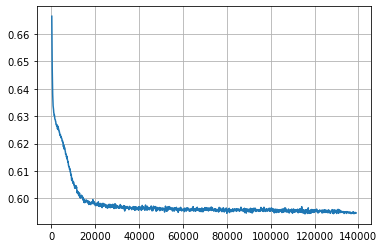

1.4770411252975464
0.0023124541640208917


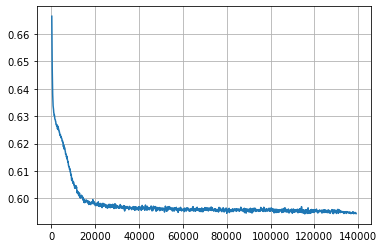

1.4674898386001587
0.002199172489308694


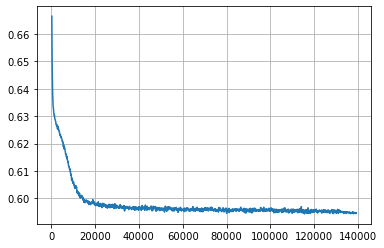

1.4790678024291992
0.002283927305870748


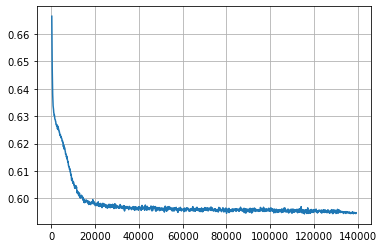

1.4849175214767456
0.002346700320194941


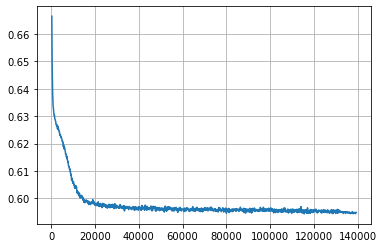

1.48029363155365
0.0023333957593422382


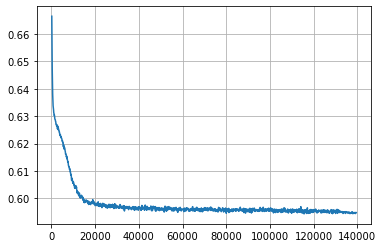

1.4761813879013062
0.0021935816046789115


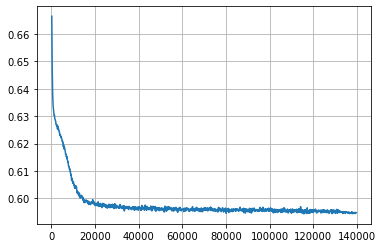

1.4767875671386719
0.0022822473116684704


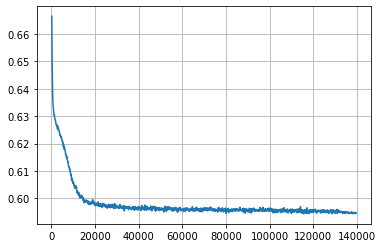

1.4707740545272827
0.0020711551042404608


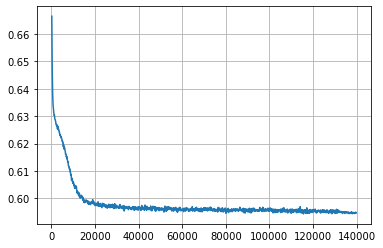

1.495449423789978
0.002337141977295687


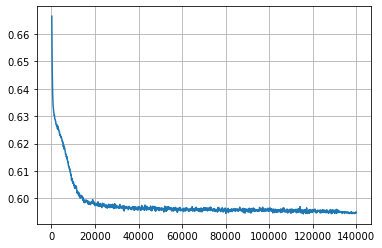

1.4744155406951904
0.0022897018155344996


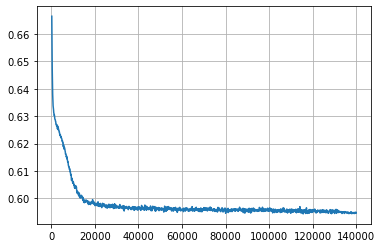

1.457403540611267
0.0022450725567978226


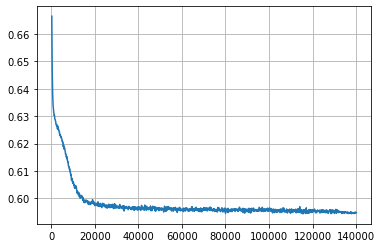

1.4548338651657104
0.0023703604232287036


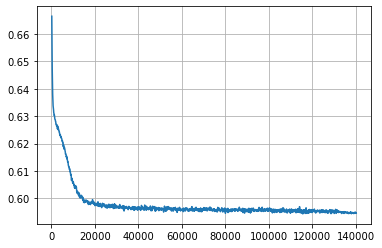

1.4364451169967651
0.0020939673345856135


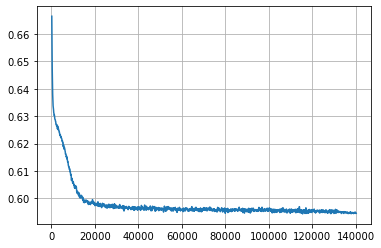

1.4961618185043335
0.00235917720832731


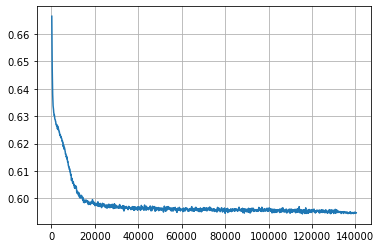

1.4543224573135376
0.002147576269999263


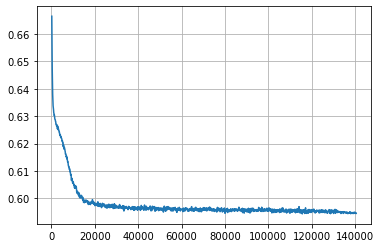

1.4861208200454712
0.002311929958377732


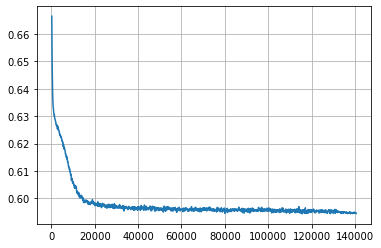

1.4679332971572876
0.0023463300840739975


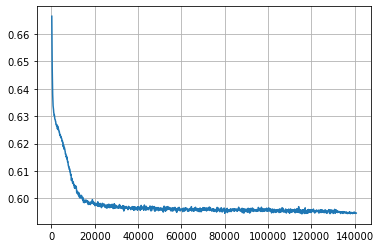

1.4853438138961792
0.0023701707457439627


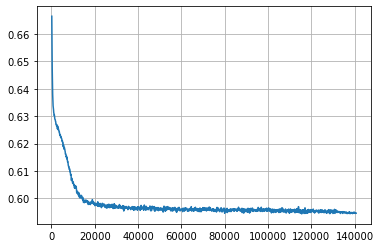

1.4942903518676758
0.0022445578029874013


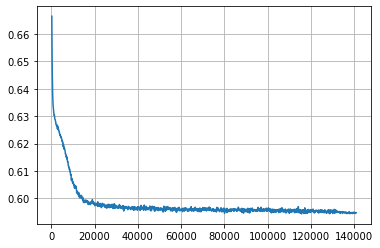

1.4603317975997925
0.0022609894791821715


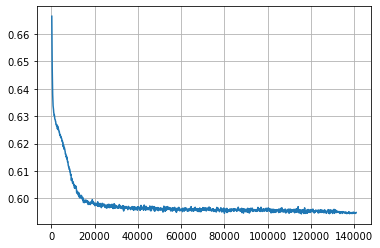

1.473862648010254
0.002216189798855339


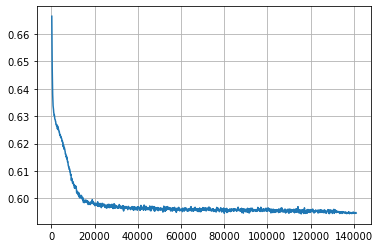

1.4581165313720703
0.0023643569904379545


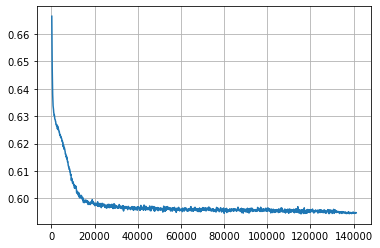

1.482322335243225
0.00227989264021744


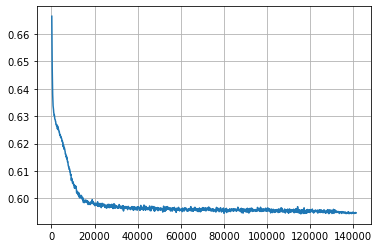

1.4569486379623413
0.0022558176171514786


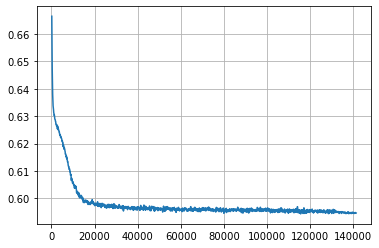

1.4706321954727173
0.0022609190535331438


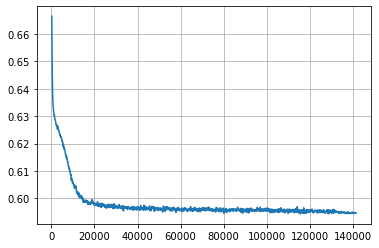

1.4727143049240112
0.00226447265027673


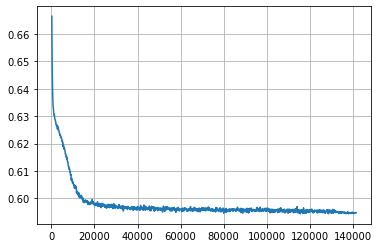

1.4806759357452393
0.002332558008565684


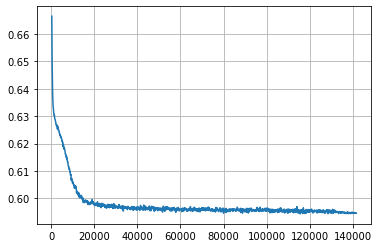

1.4910235404968262
0.002381276938940573


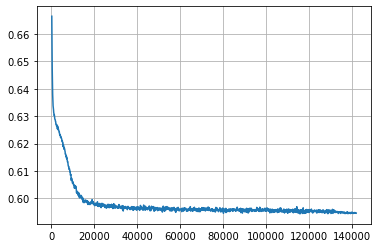

1.4752273559570312
0.002326713255533832


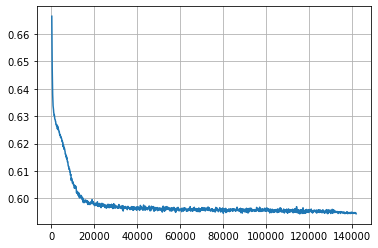

1.4759637117385864
0.002225239288090961


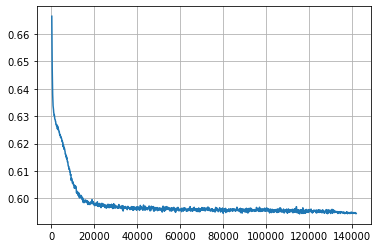

1.4770374298095703
0.002330979613579984


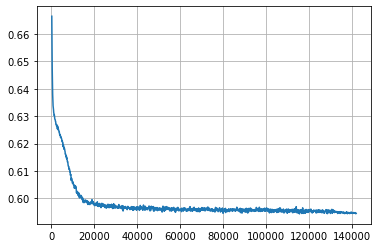

1.4539508819580078
0.0024350334347764146


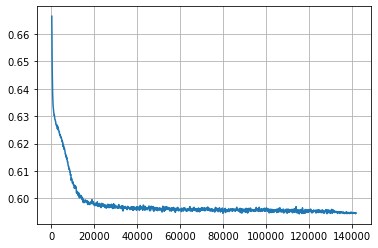

1.484608769416809
0.0023753740986285268


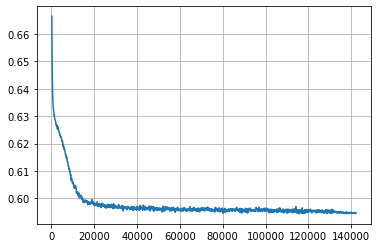

1.4806578159332275
0.0021741719431520325


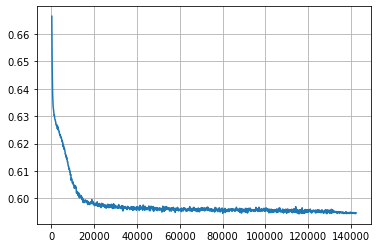

1.4694769382476807
0.0023155423626303674


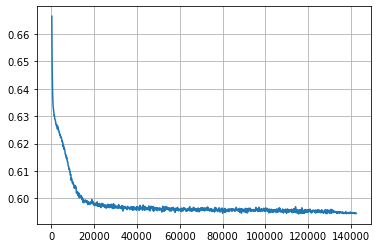

1.4537380933761597
0.00224066409853549


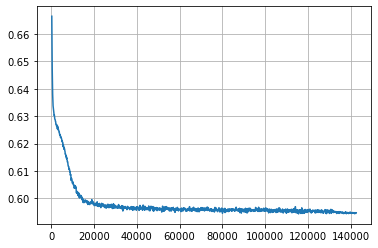

1.4751052856445312
0.002401590091831167


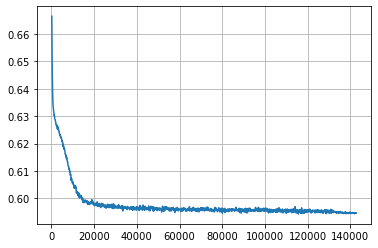

1.4626060724258423
0.002371197555876279


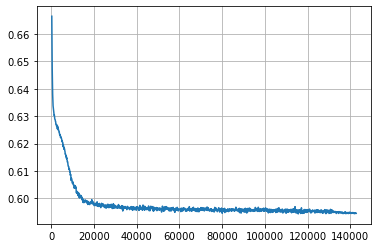

1.4696245193481445
0.0023185135711173642


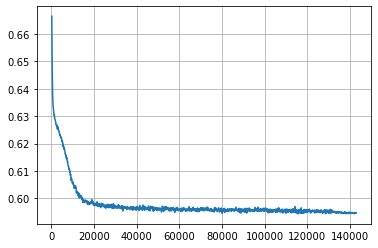

1.4915951490402222
0.0023063220719996024


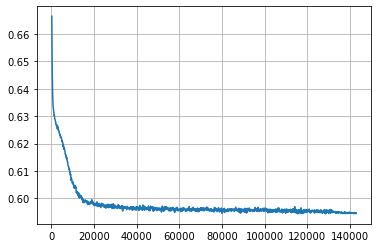

1.4795637130737305
0.0021238445458584467


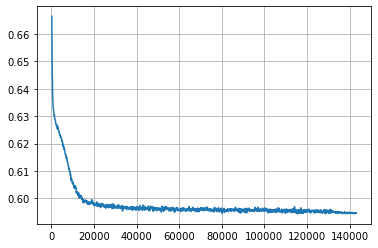

1.4724621772766113
0.0023076045070774855


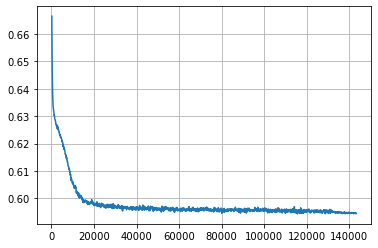

1.4806828498840332
0.002175602942807018


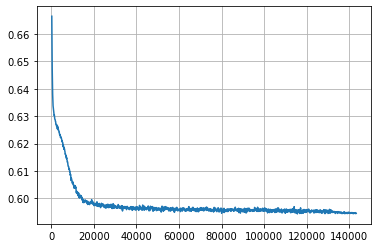

1.4886201620101929
0.0023970672146970172


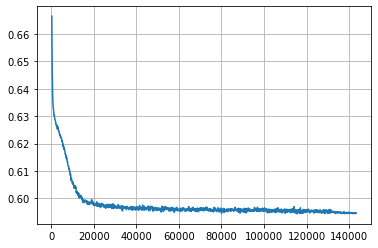

1.4723255634307861
0.0021250657886776026


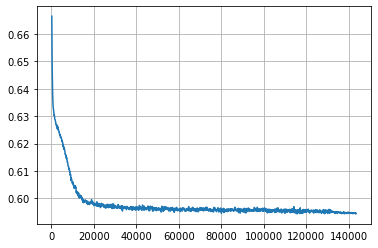

1.4985164403915405
0.0023900635274185333


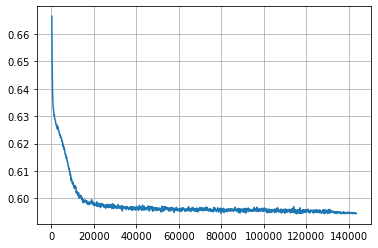

1.4660462141036987
0.002250459987517388


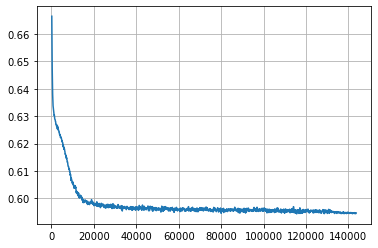

1.47124445438385
0.002423845586599782


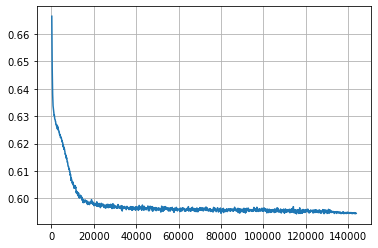

1.4869135618209839
0.0024740775207828846


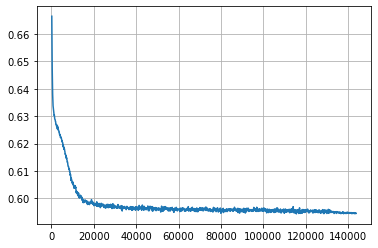

1.4482355117797852
0.0021736166095070075


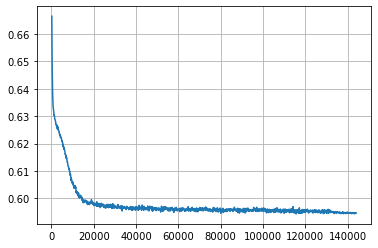

1.4683724641799927
0.002274215679062763


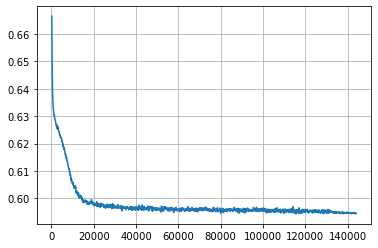

1.499327540397644
0.0021299553882636246


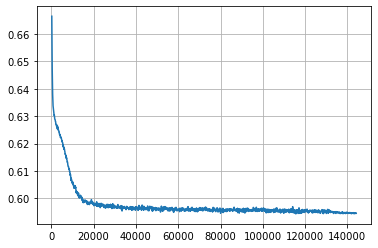

1.4858659505844116
0.0023219162380701164


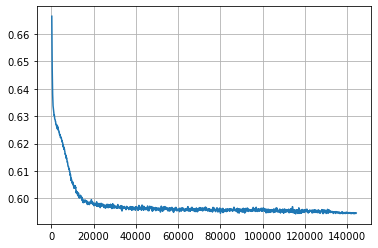

1.482563853263855
0.0024515342420636443


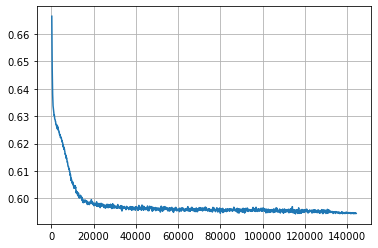

1.4763151407241821
0.0022101217022282072


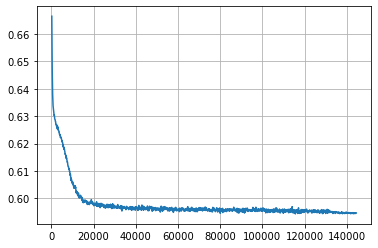

1.4804028272628784
0.002317432700583595


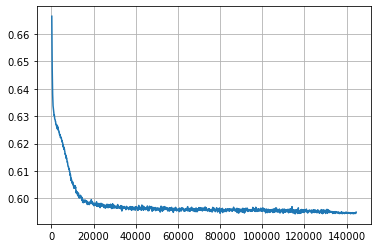

1.4594916105270386
0.0021817425801782518


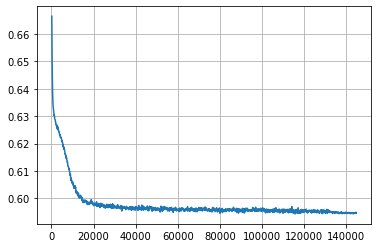

1.4600127935409546
0.0022082300765396213


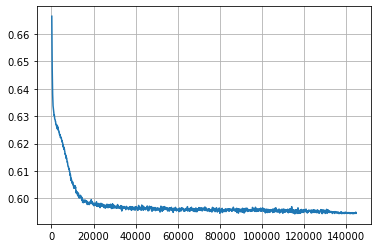

1.4455493688583374
0.002214408159015875


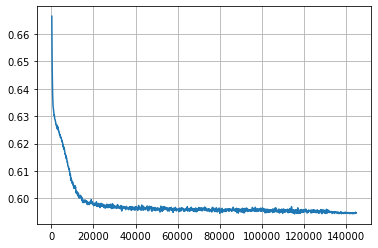

1.4873833656311035
0.002170475663006073


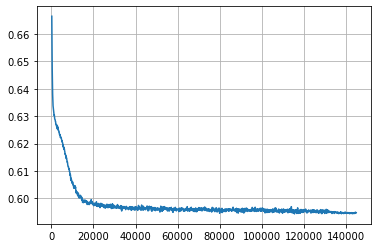

1.4634851217269897
0.0021870539488008946


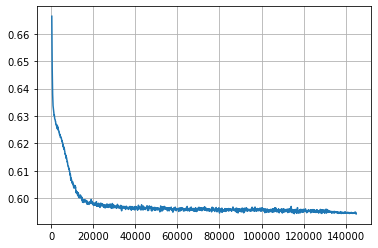

1.5079916715621948
0.002359334702123306


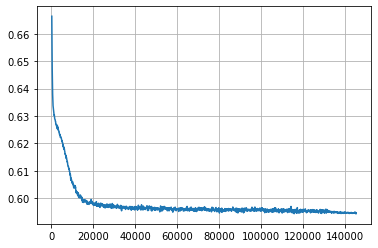

1.4693769216537476
0.0020643063406896546


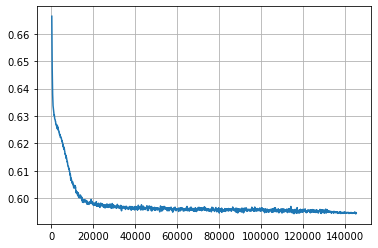

1.491312026977539
0.002310694895313645


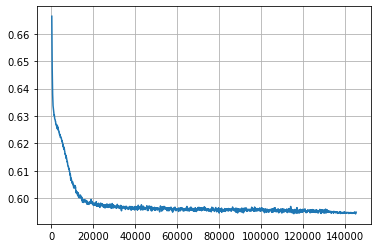

1.472294807434082
0.0023351160671154503


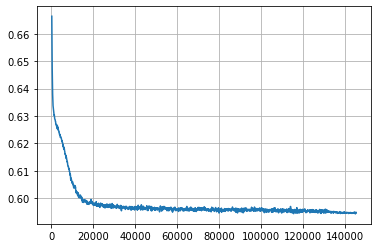

1.478587031364441
0.002333916233983473


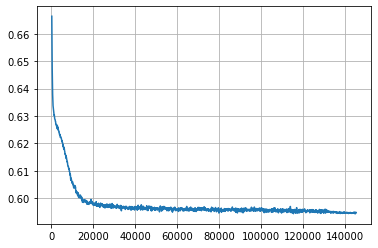

1.509130835533142
0.0022463490407608334


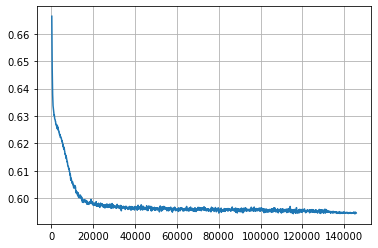

1.4703280925750732
0.0022977129442006117


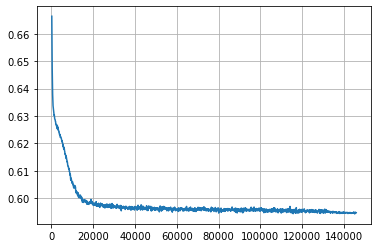

1.4929344654083252
0.0022331823670174345


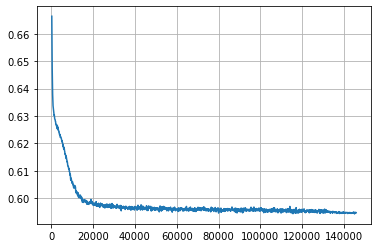

1.4781930446624756
0.0024315487103376654


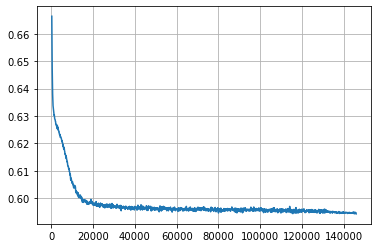

1.477624773979187
0.0021277251709398114


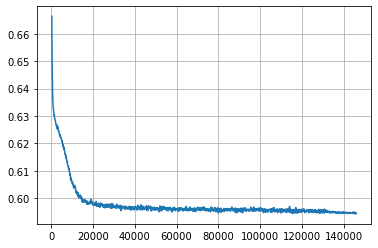

1.478049397468567
0.0021137368017662083


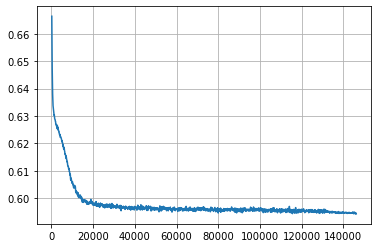

1.472344994544983
0.0022683792456155063


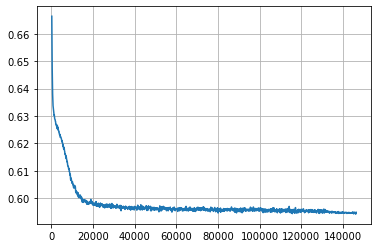

1.467075228691101
0.0023895674293817138


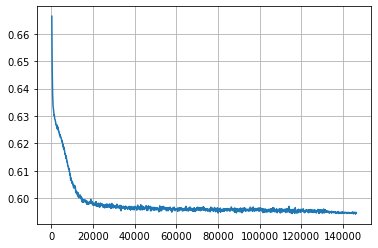

1.4940518140792847
0.0024272882111472426


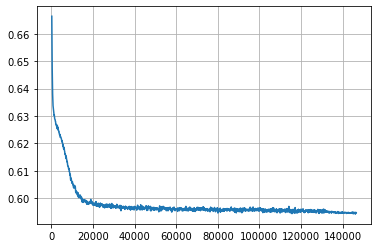

1.4742754697799683
0.0023999866689700866


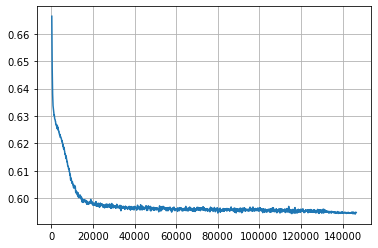

1.4698199033737183
0.0023298624512244712


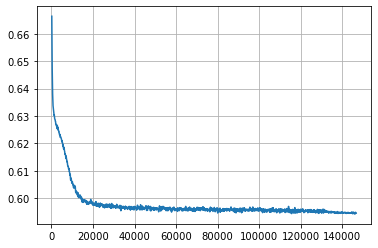

1.4753237962722778
0.0023341230066580465


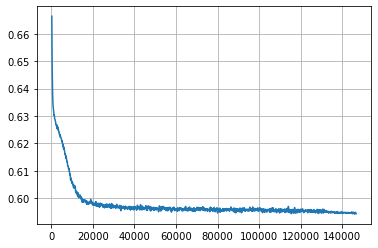

1.4602680206298828
0.0024292786132718903


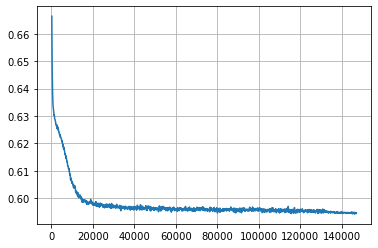

1.4758137464523315
0.0023420734556930255


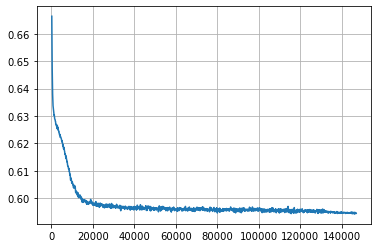

1.4962953329086304
0.002352140863149543


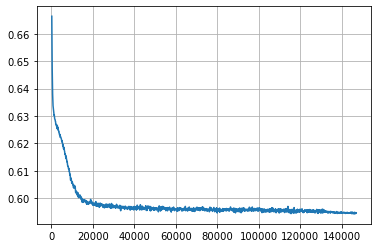

1.4932750463485718
0.0022979741236849806


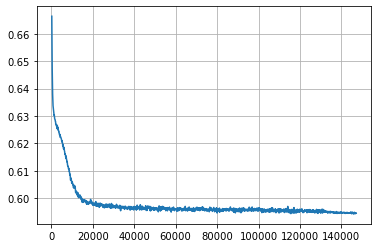

1.4731860160827637
0.002264318153520435


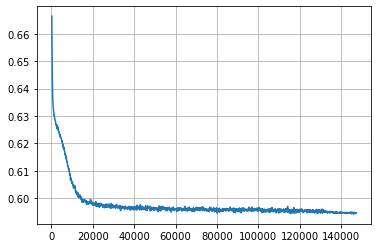

1.479784369468689
0.0022795091827356373


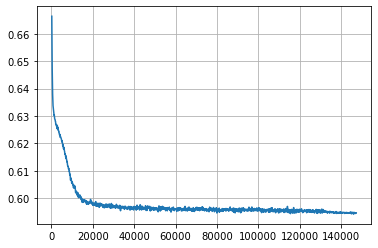

1.4576748609542847
0.0023451698432108968


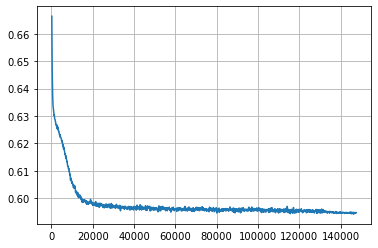

1.469691276550293
0.0023342771228635683


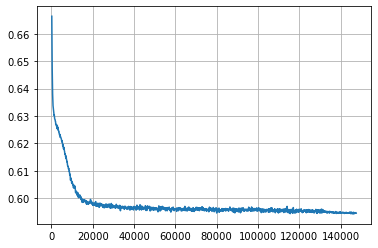

1.489565372467041
0.002376418418789399


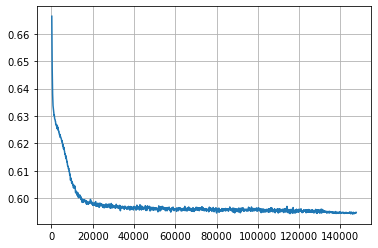

1.4500651359558105
0.0023527365056361304


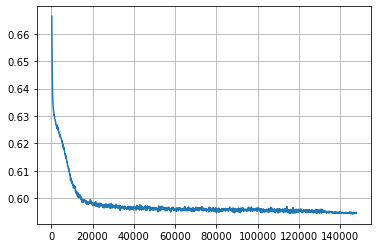

1.478668451309204


KeyboardInterrupt: 

In [100]:
BCE = nn.BCELoss()
MSE = nn.MSELoss()
LogSoftmax = nn.LogSoftmax()
losses = []
slosses = []

for _ in trange(400000):
    
    # Supervised Learning
    x, yt1, yt2 = next(bg)
    x, yt1, yt2 = np2t(x, yt1, yt2)
    yp = net(x)
    yp = yp * x[:,:,:,[1]] + 0.5 * (1-x[:,:,:,[1]])
    loss = BCE(yp.view(-1), yt1.view(-1))
    loss2 = -torch.mean(torch.sum(LogSoftmax(net.res_ships) * yt2, axis=[1]))
    losses += [loss.item()]
    (loss+loss2).backward()
        
    # Semisupervised Learning
    x, _, _ = next(bg)
    x = np2t(x)
    with torch.no_grad():
        y = teacher(x)
    x, y = augment(x, y)
    y2 = net(x)
    sloss = 50*MSE(y, y2)
    sloss.backward()
    slosses += [sloss.item()]
    
    optimizer.step()
    optimizer.zero_grad()
    update_mt(teacher, net, tau)
    
    if len(losses) == 100:
        #print(np.mean(losses))
        print(np.mean(slosses))
        net.losses.append((net.iters, np.mean(losses)))
        losses = []
        slosses = []
        
    if net.iters % 100 == 0:
        plt.plot(*zip(*net.losses))
        #plt.ylim([0.58, 0.6])
        plt.grid()
        plt.show()
        print(loss2.item())
        
    if net.iters % 1000 == 0:
        with open('data/__battleships_unet.dat', 'wb') as f:
            torch.save(net.state_dict(), f)
        
    net.iters += 1
        
# 120000: tau->0.99, bs->1024, lr->1e-5

In [55]:
LogSoftmax(net.res_ships).shape#* yt2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


torch.Size([512, 4, 10, 10])

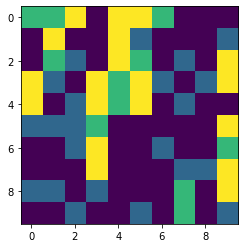

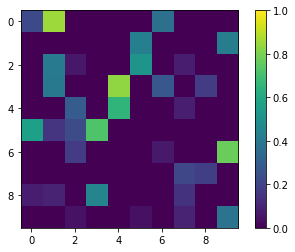

In [97]:
sea = njit_create_sea()
#det = create_detection()
det = np.random.rand(10,10) < 0.75
prob = net.predict(encode_x(sea, det))
prob[det > 0] = 0
plt.imshow(visualize(sea, det))
plt.show()
plt.imshow(prob, vmax=1.)
plt.colorbar()
plt.show()

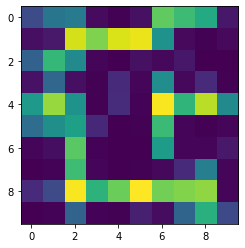

In [98]:
sea = njit_create_sea()
prob = net.predict(encode_x(sea, det))
plt.imshow(prob)

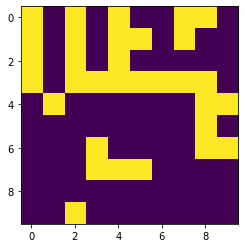

In [89]:
sea = np.zeros((10,10))
det = np.zeros((10,10))
while np.any(1-det):
    prob = net.predict(encode_x(sea, det))
    prob[det > 0] = 0
    ij = np.random.choice(range(100), p=prob.flatten()/np.sum(prob))
    i, j = divmod(ij, 10)
    det[i,j] = 1
    sea[i,j] = 1 if np.random.rand()<prob[i,j] else 0

    #plt.imshow(visualize(sea, det))
    #plt.show()
    #plt.imshow(prob, vmax=1.)
    #plt.show()
    
plt.imshow(visualize(sea, det))

### AI spielt

In [28]:
from vidcapture import *

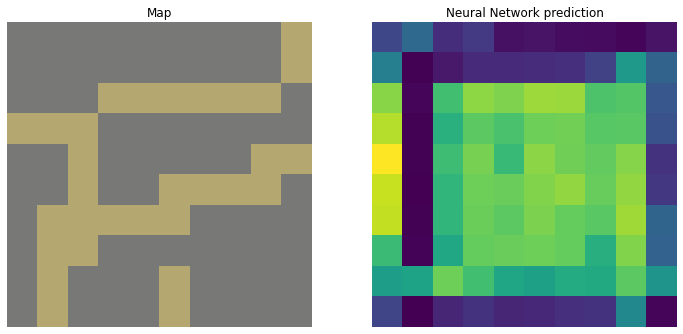

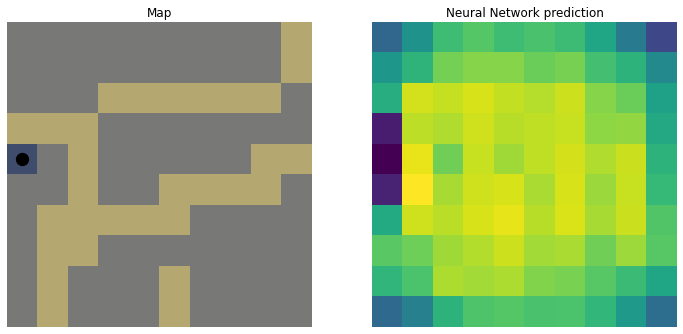

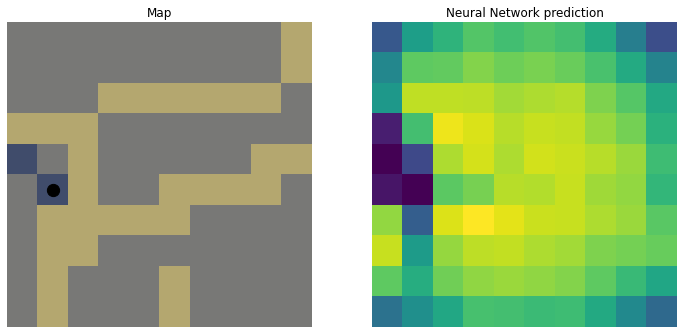

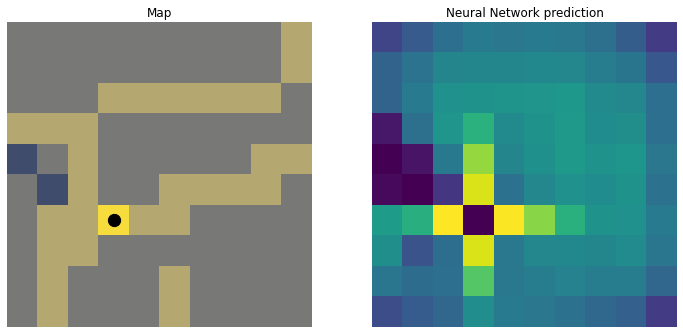

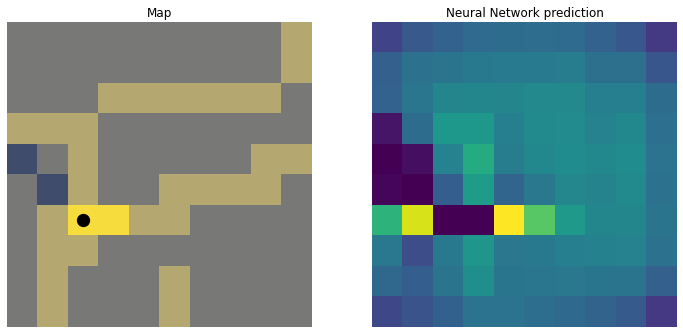

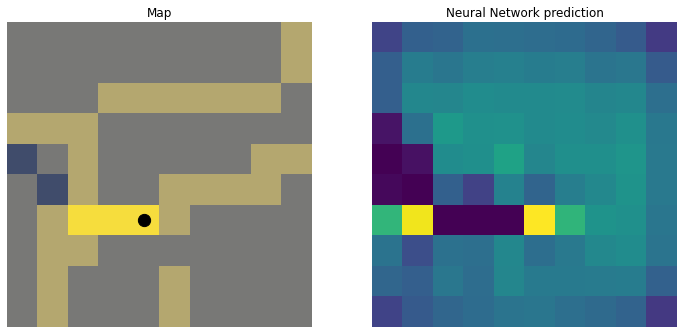

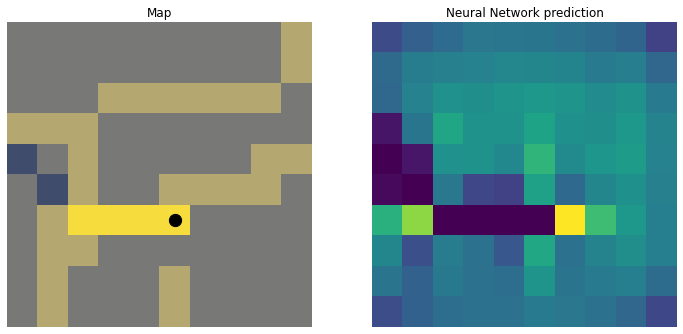

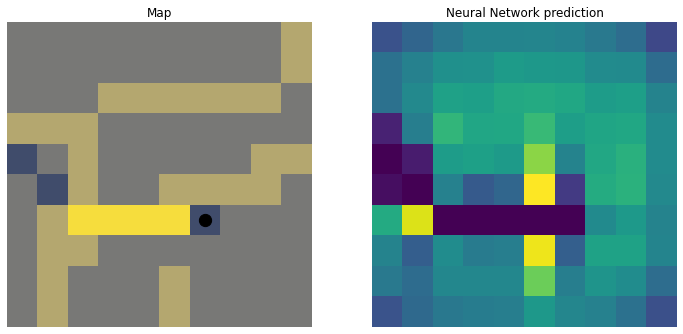

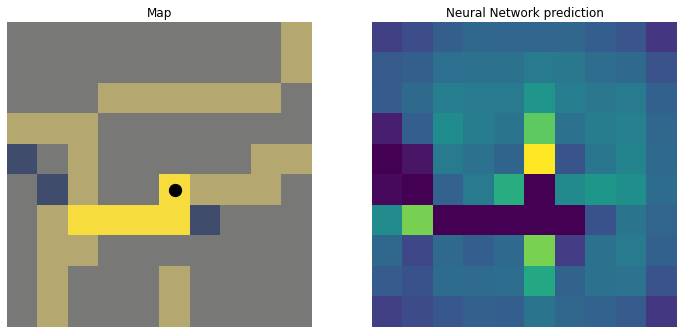

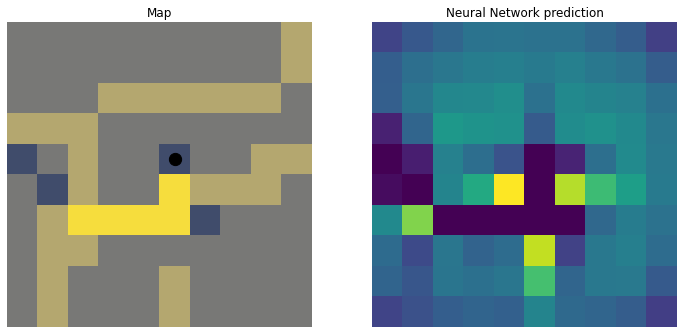

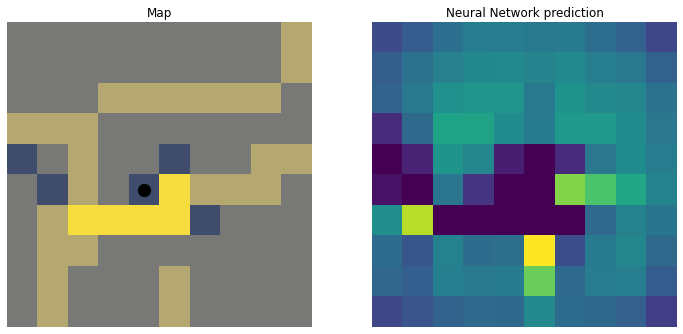

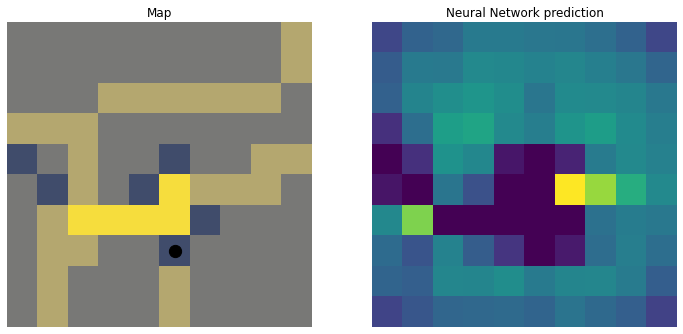

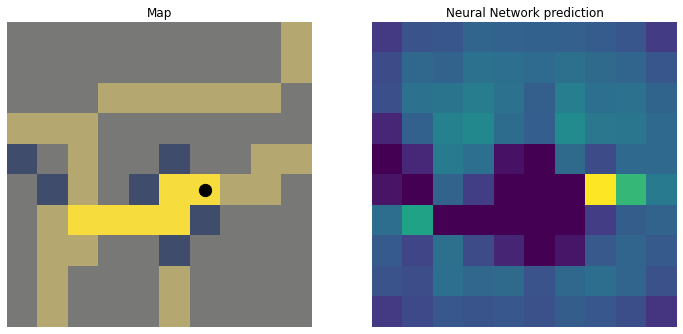

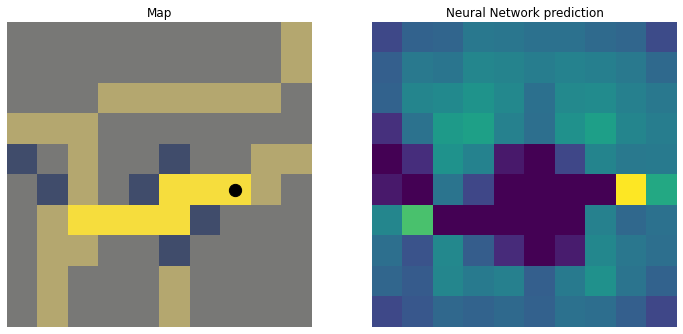

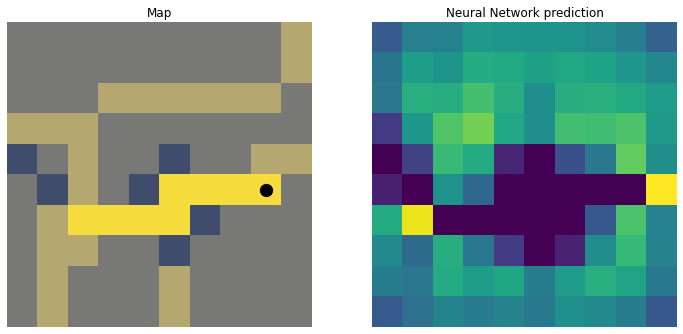

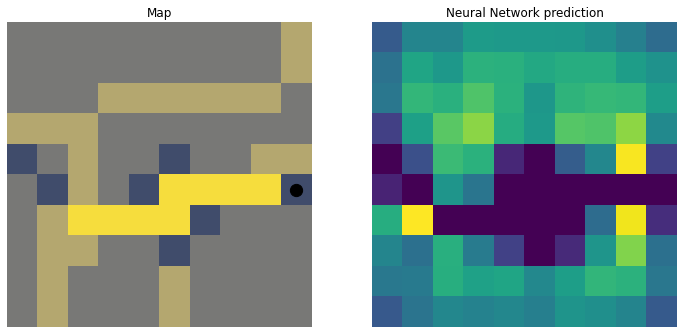

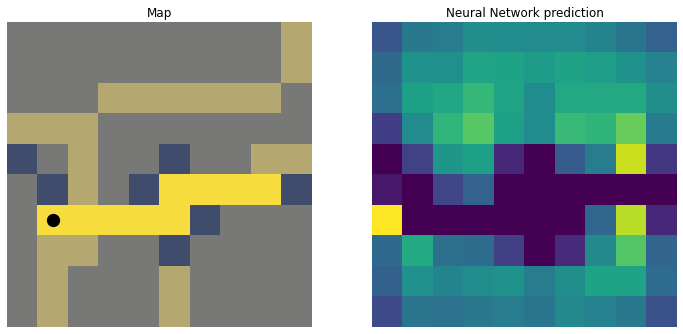

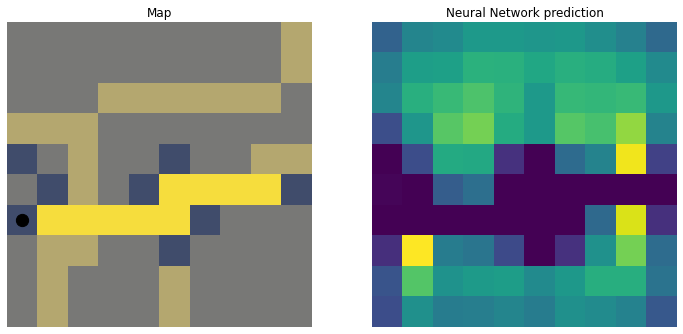

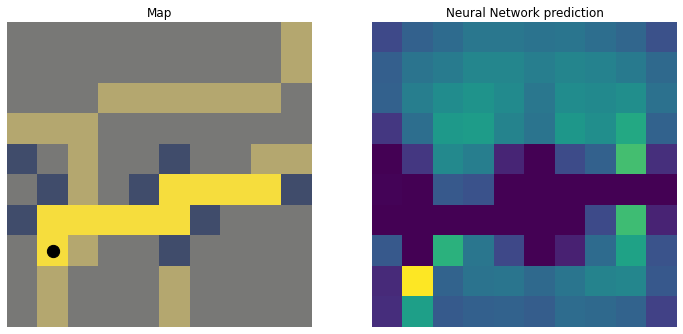

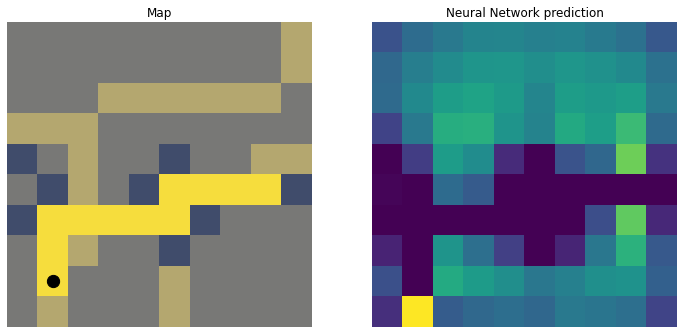

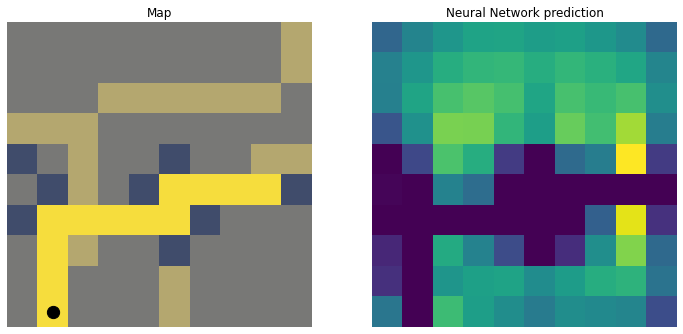

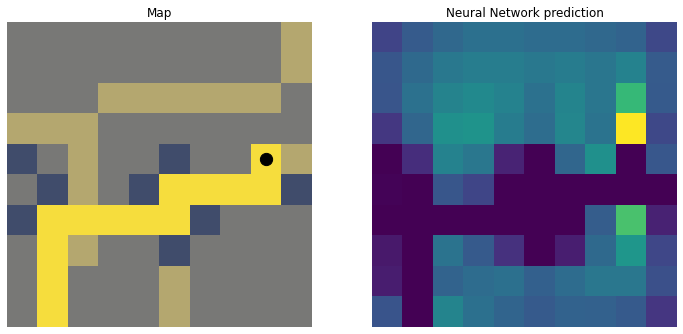

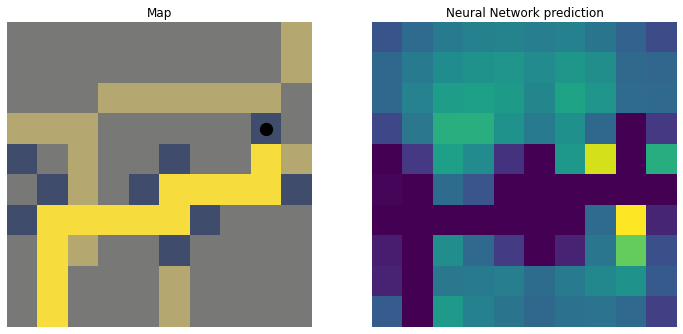

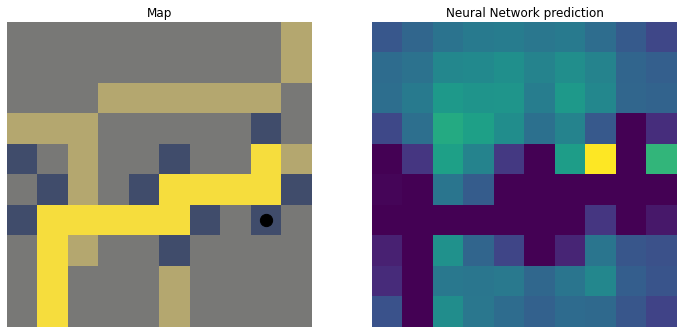

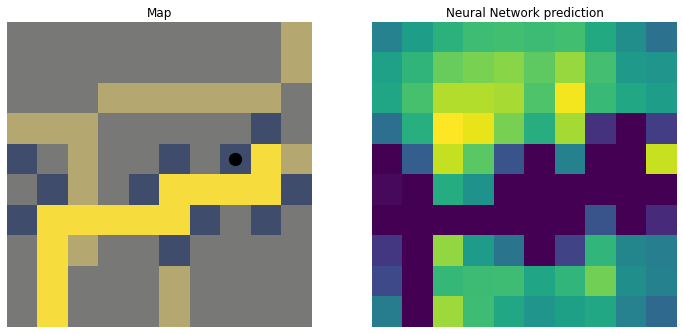

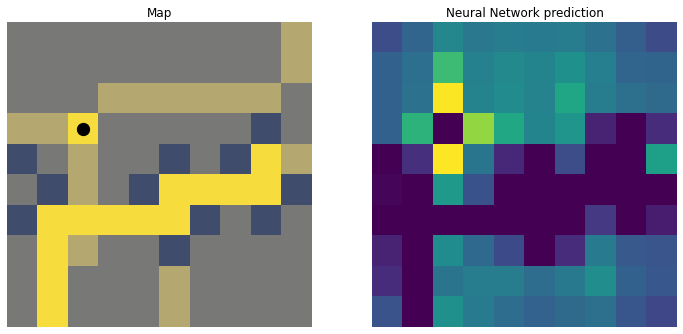

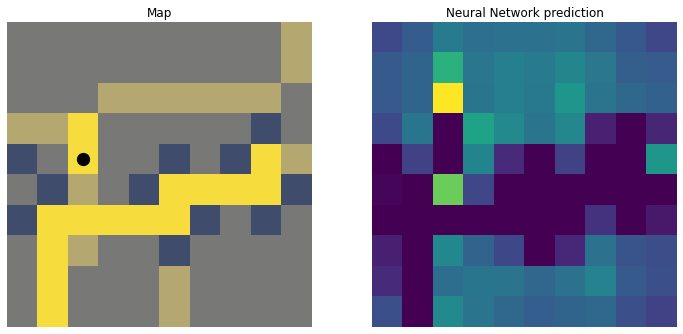

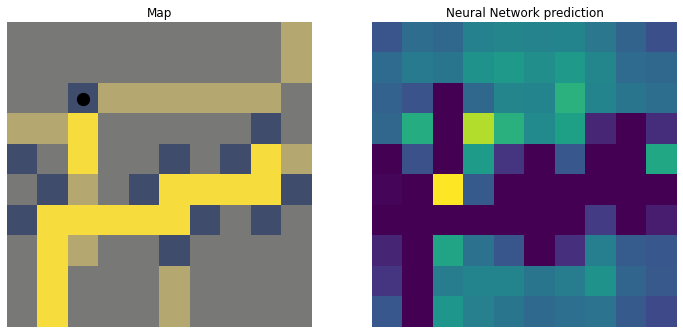

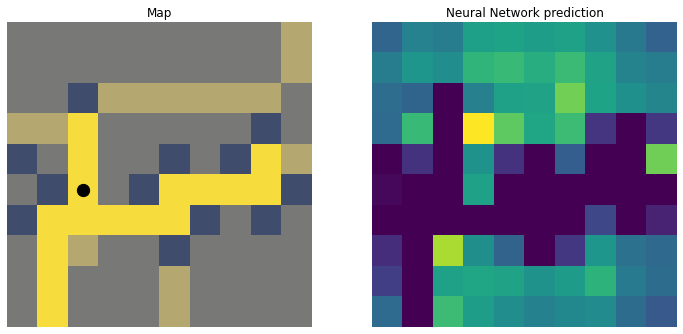

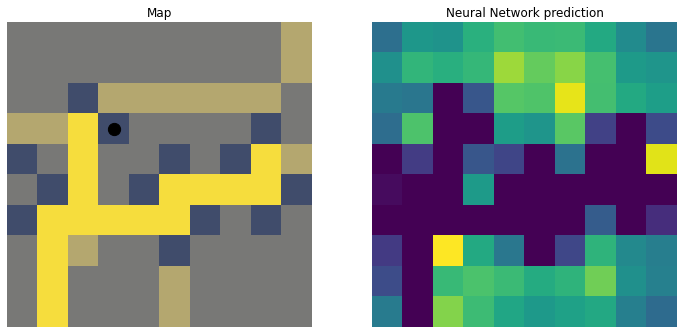

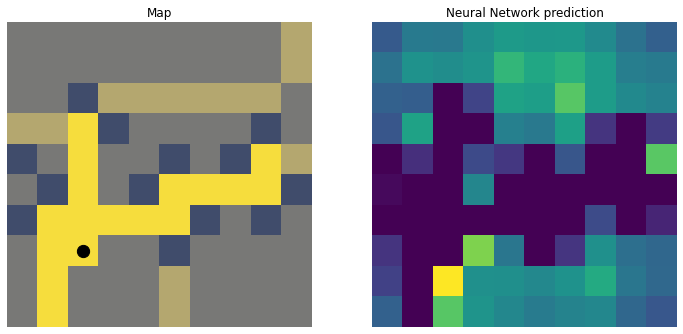

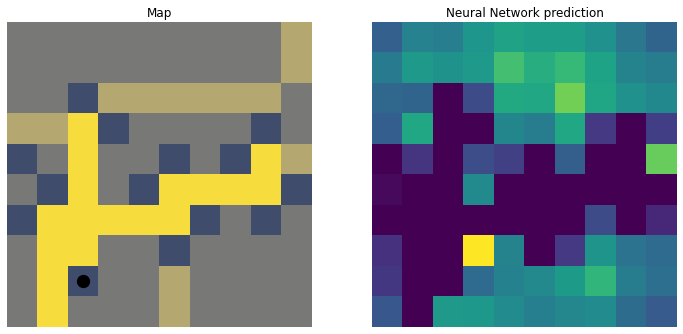

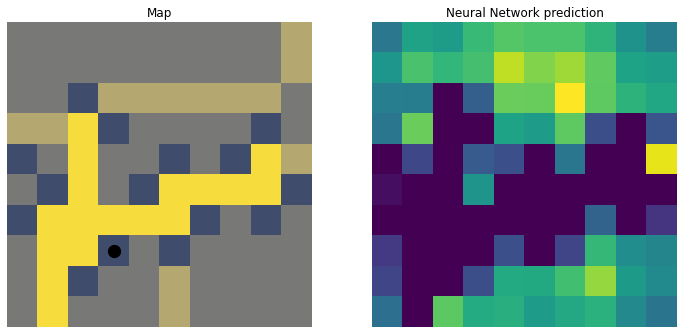

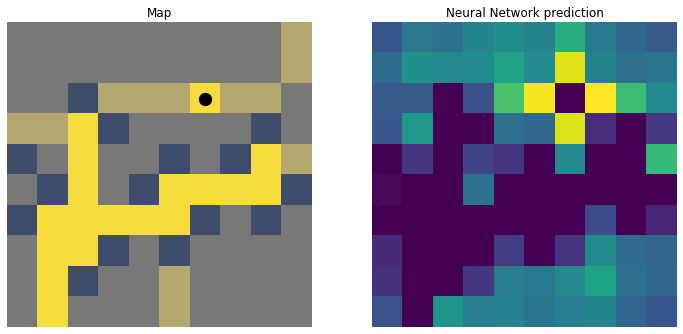

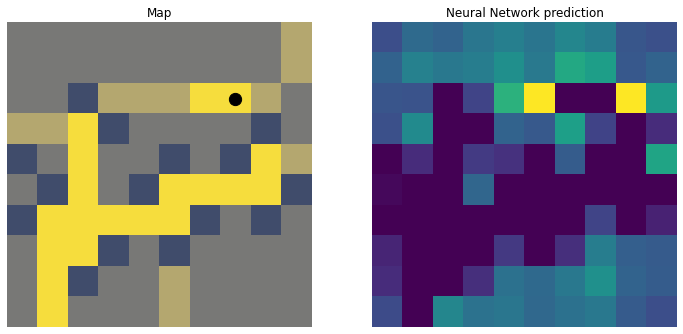

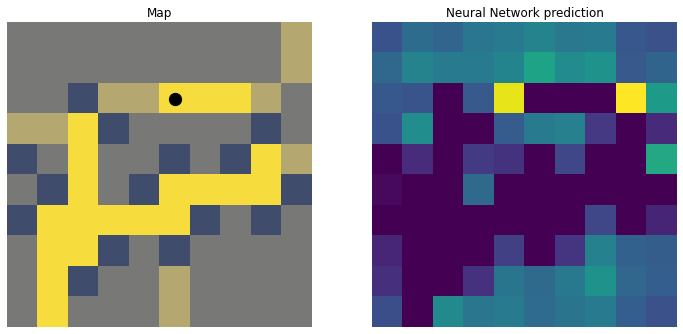

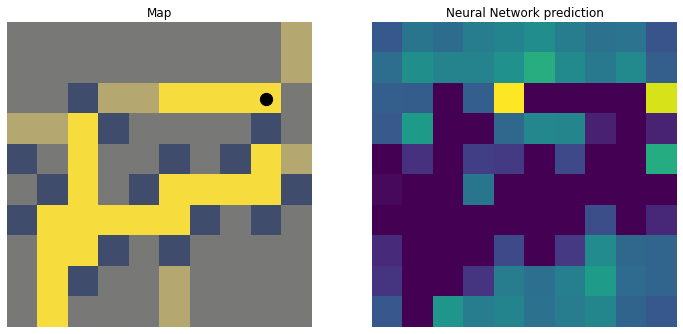

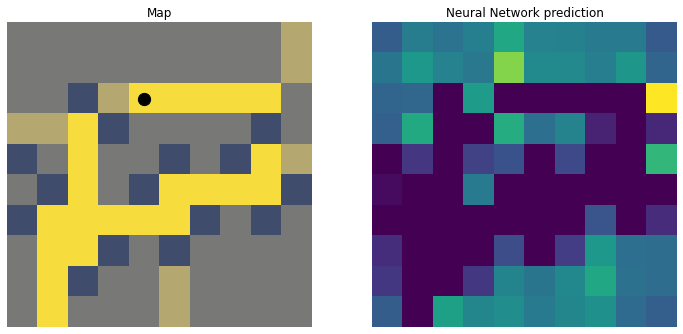

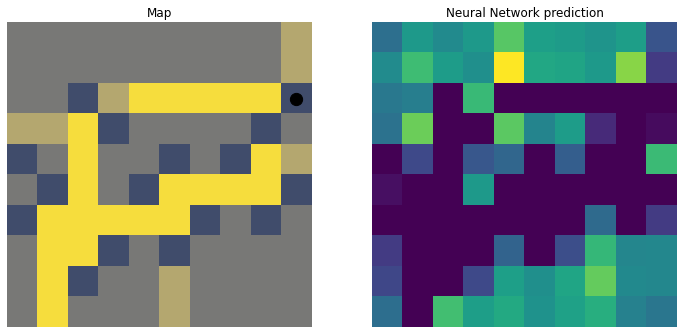

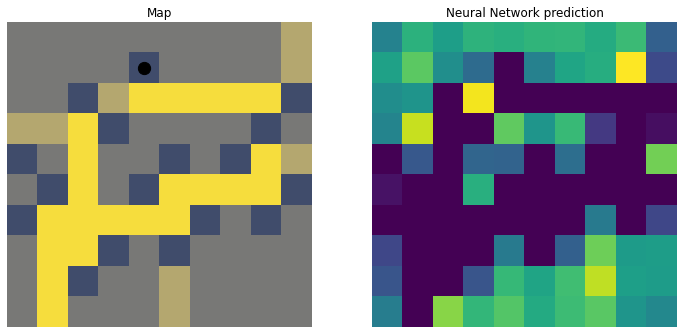

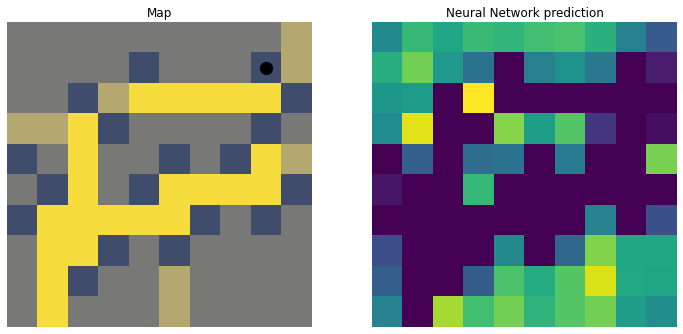

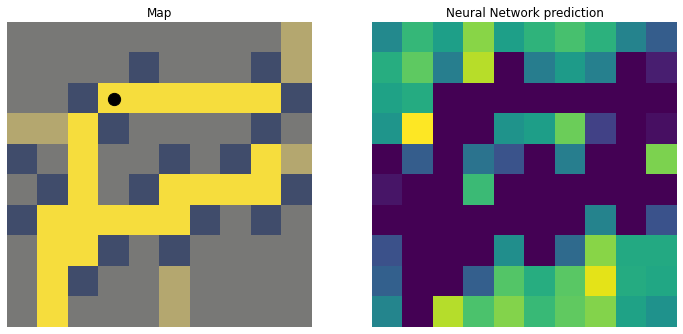

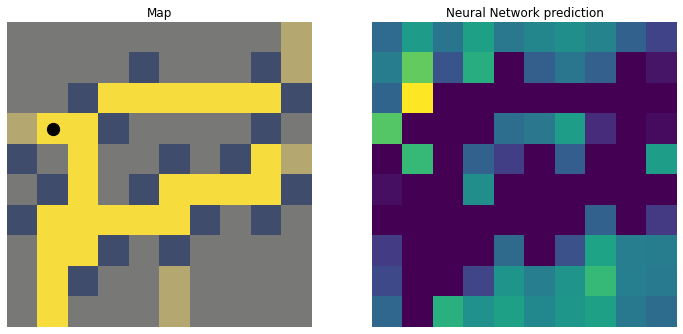

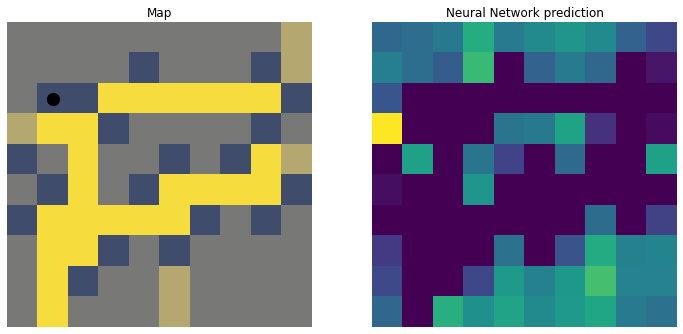

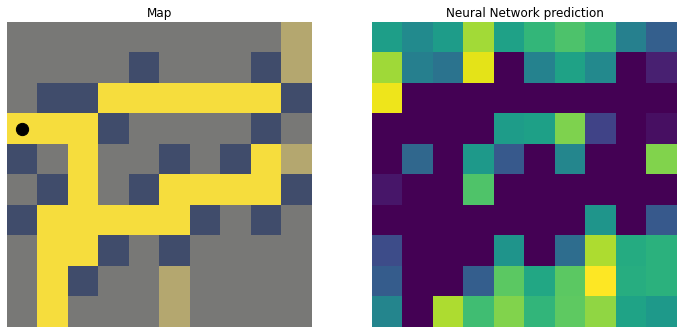

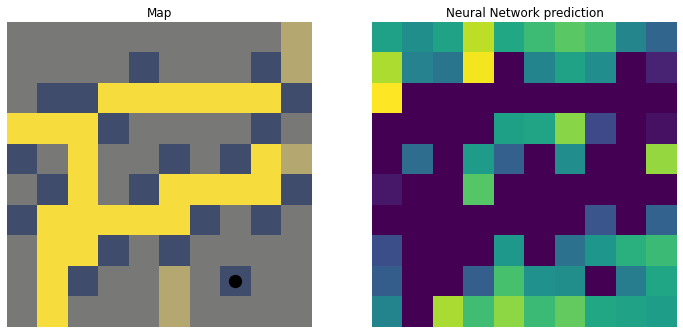

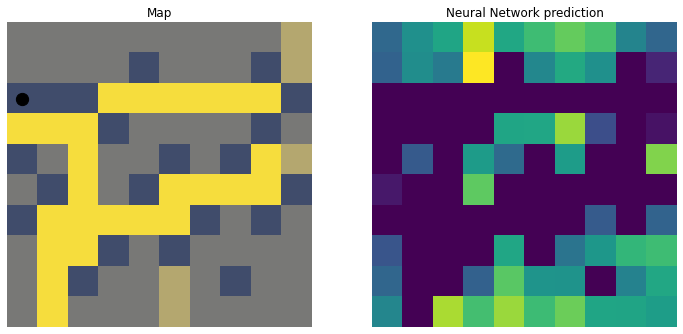

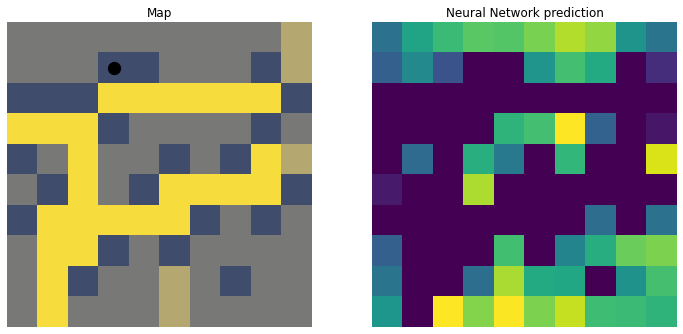

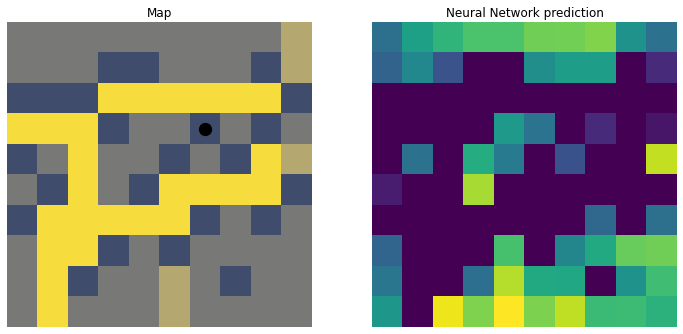

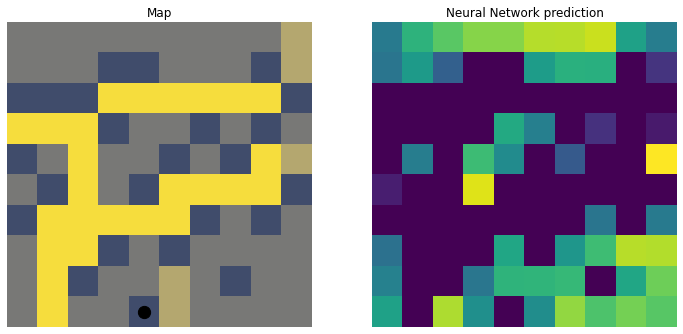

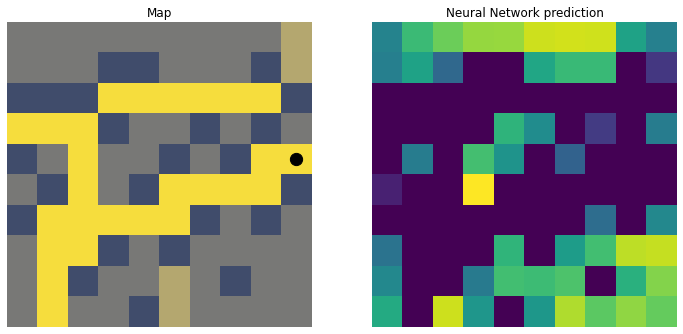

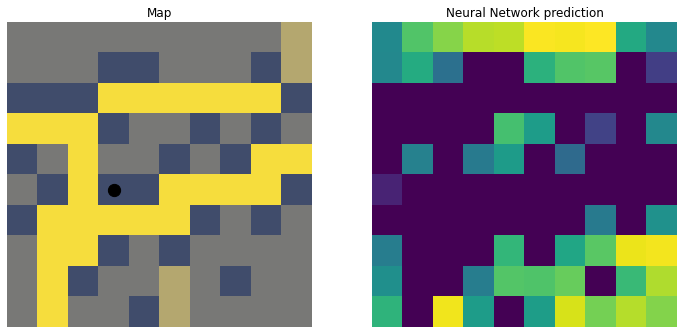

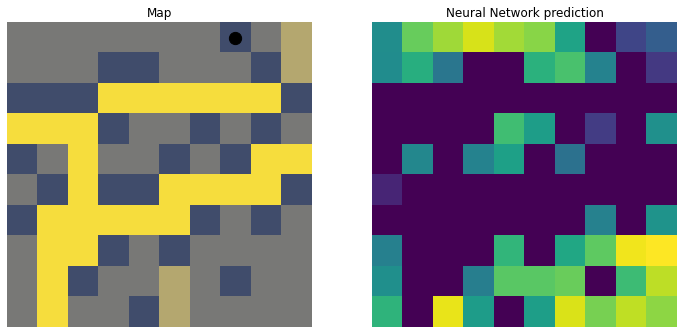

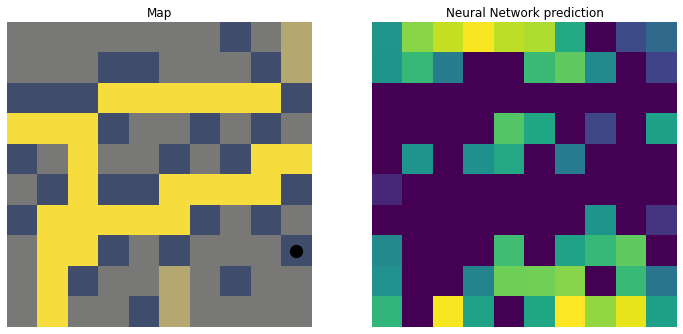

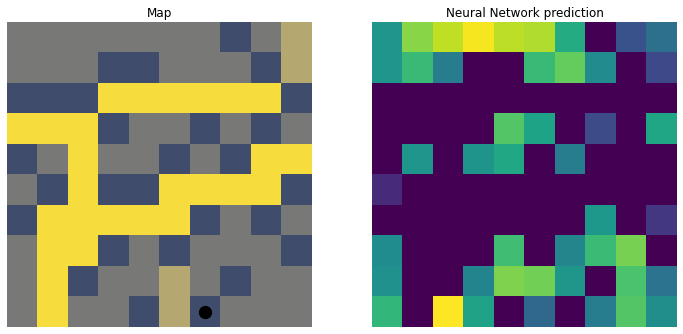

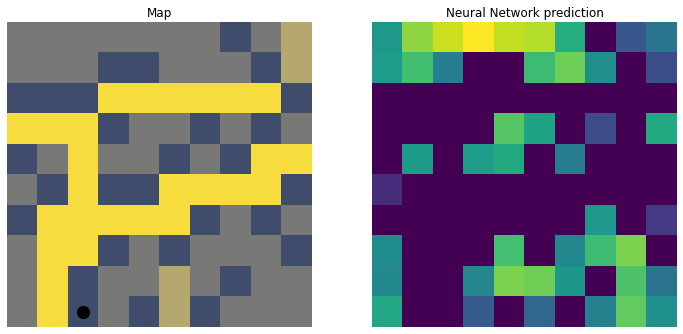

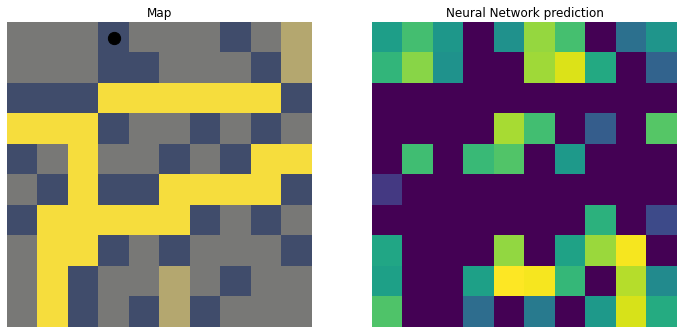

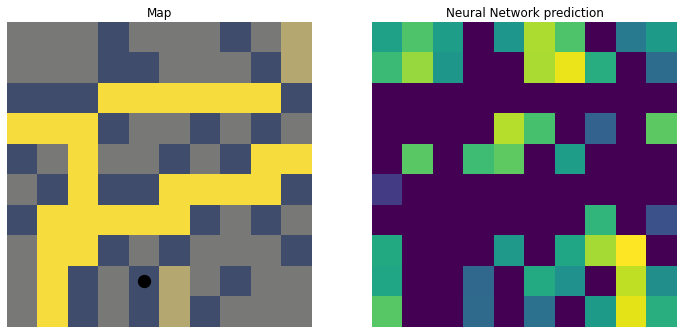

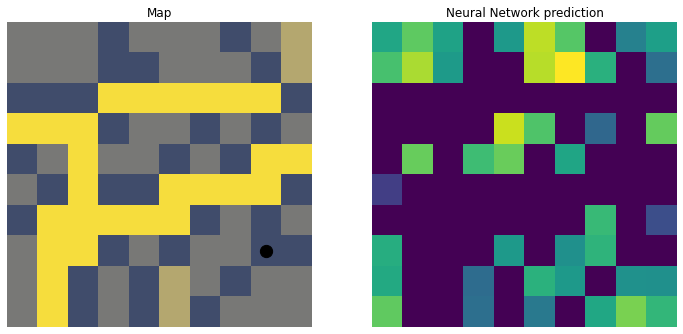

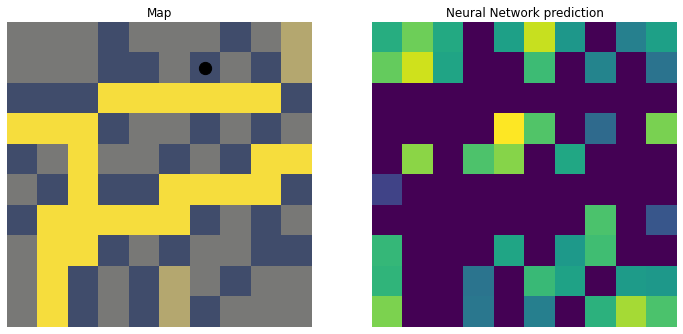

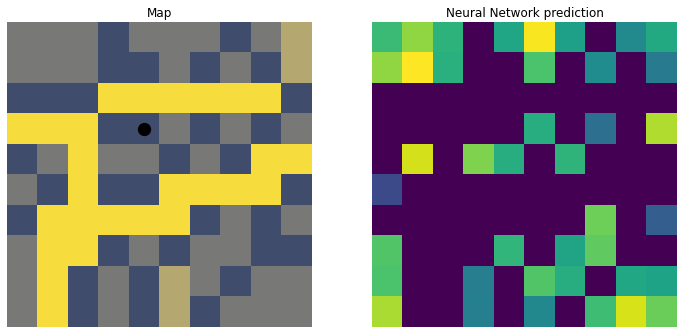

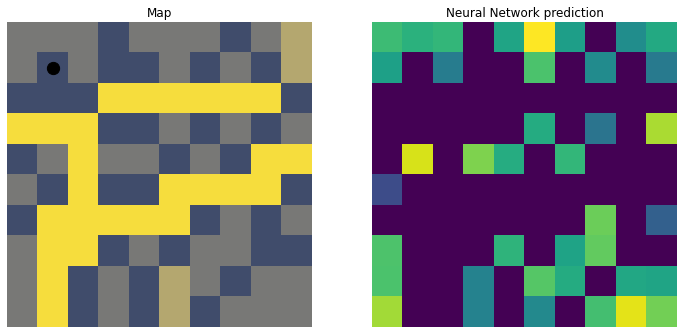

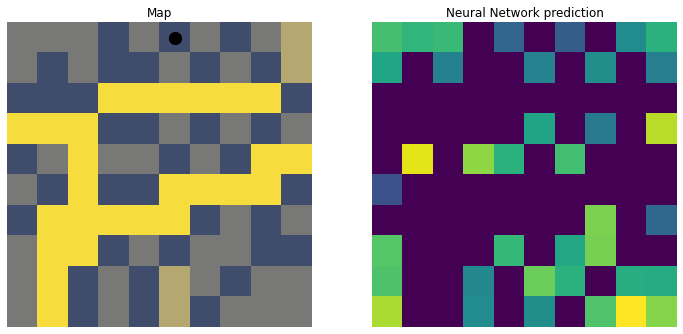

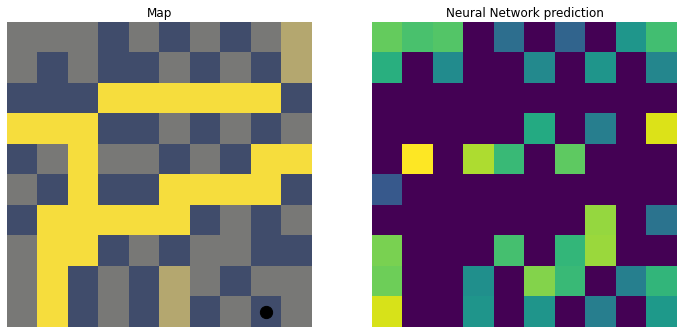

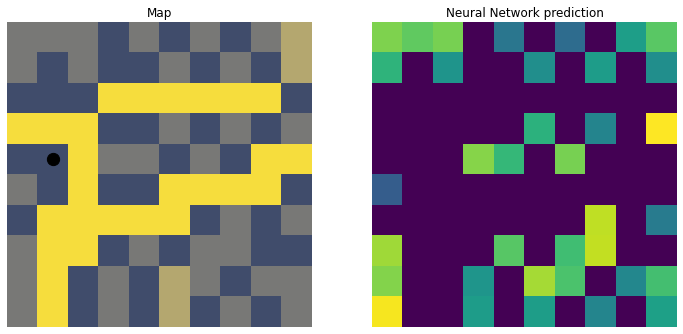

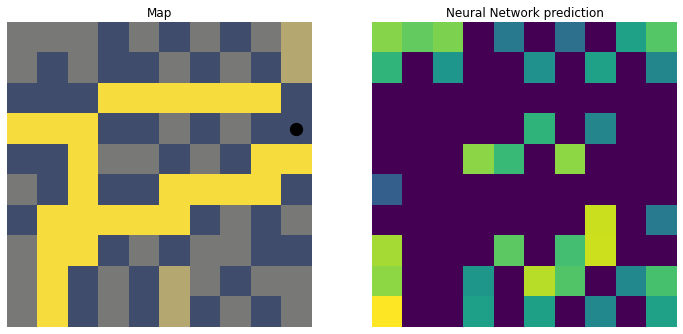

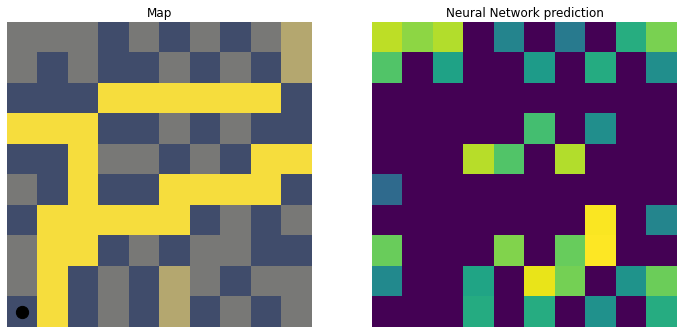

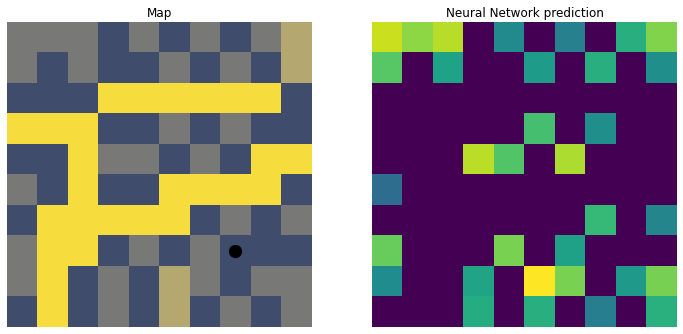

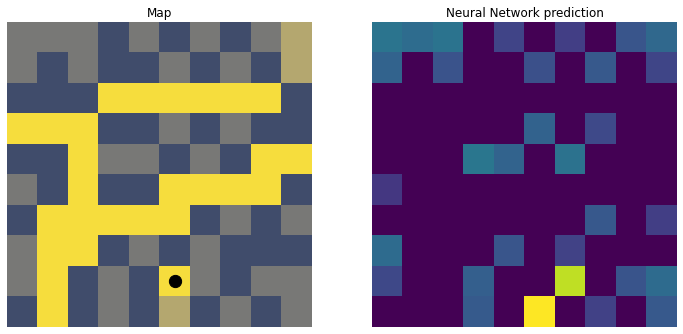

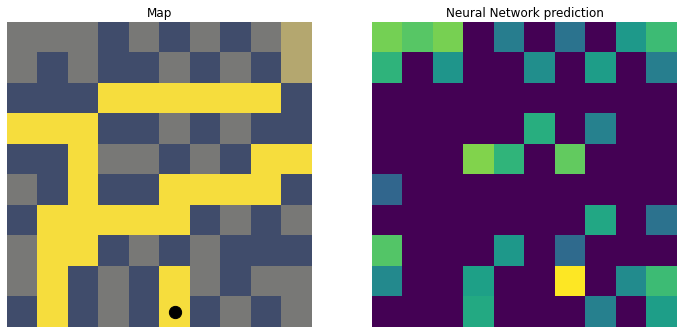

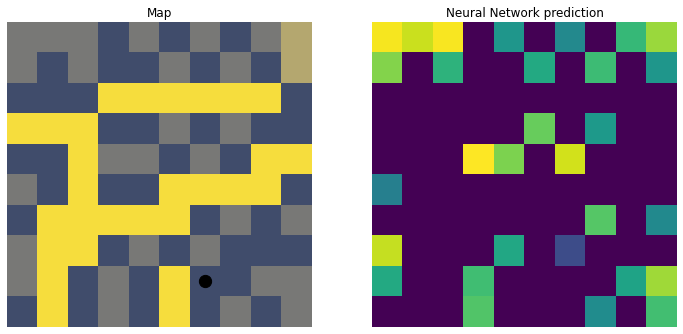

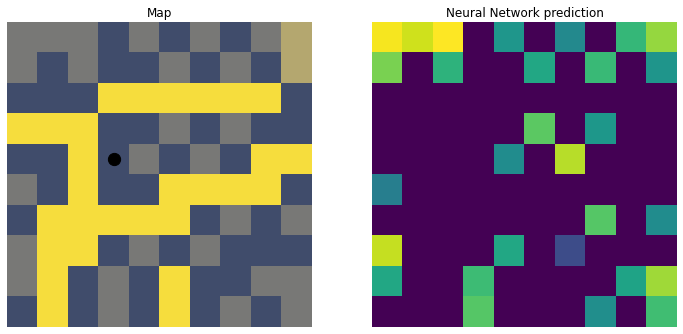

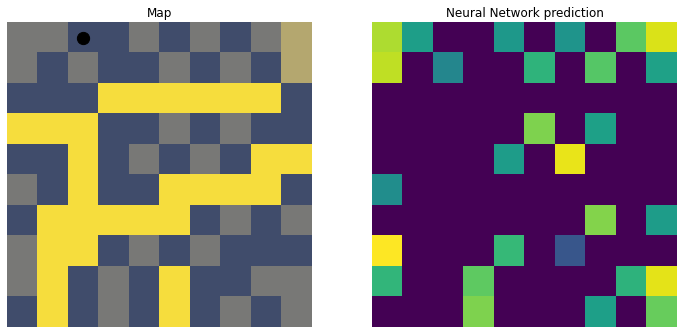

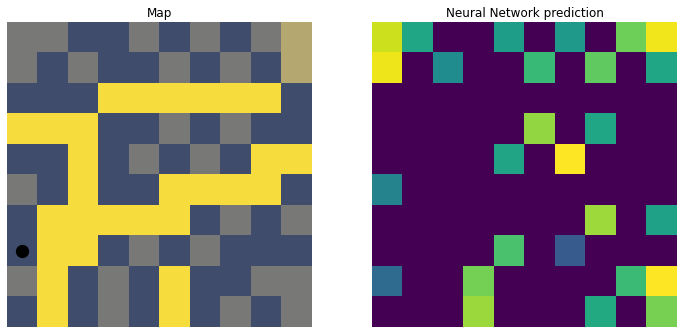

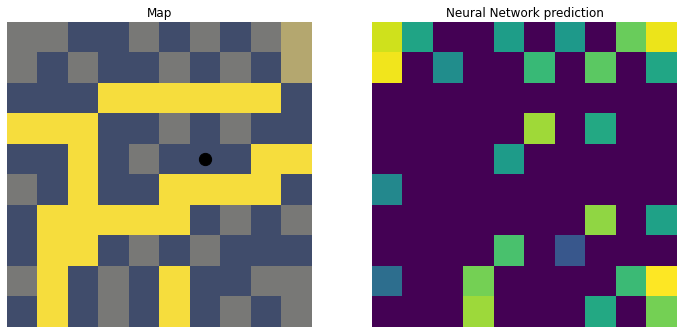

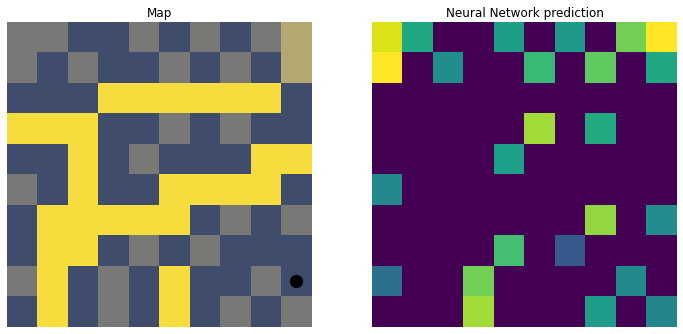

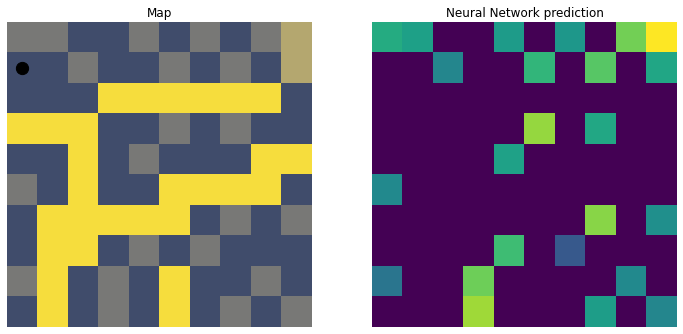

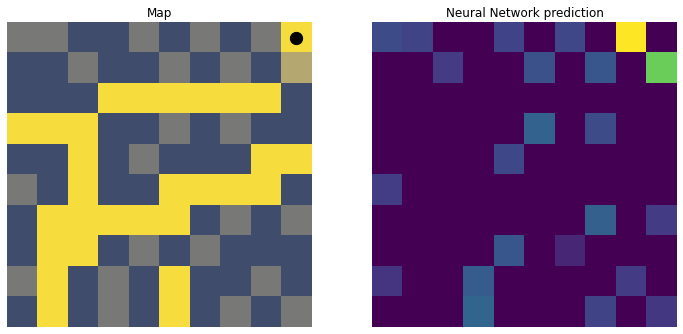

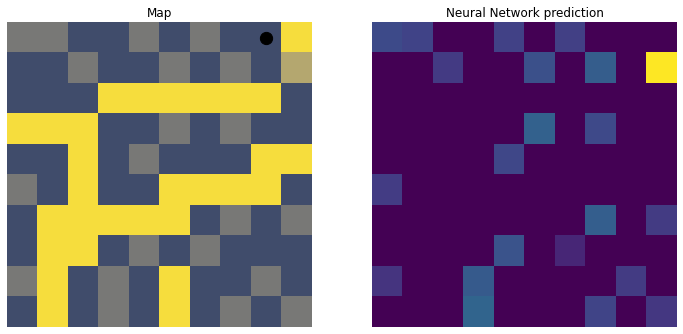

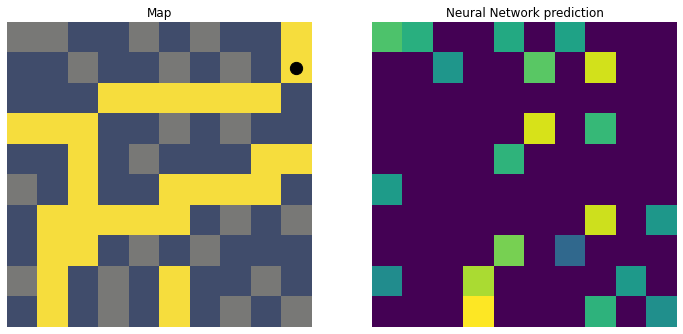

In [32]:
# gegeben: sea, model
det = np.zeros((10,10))
sea = create_sea(100)
##det = create_detection()
i,j = [],[]
vc = vidcapture('F:/$Daten/vidcaptures/battleships cnn/frame%05d.png')

while True:
    prob = net.predict(encode_x(sea, det))
    prob[det > 0] = 0
    percent = 0. if np.sum(det)==0 else 100*np.sum(det*sea)/(np.sum(det)+1e-2)
    text = f'Hits: %d, Shots: %d, Percentage: %.1f %%' % (np.sum(det*sea), np.sum(det), percent)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.title.set_text('Map')
    ax2.title.set_text('Neural Network prediction')
    ##fig.text(1/2,0.8, text, fontdict={})
    ax1.axis('off')
    #ax1.imshow(visualize(sea, det), vmin=0., vmax=3.)
    plot_sea(sea, det, ax1)
    ax1.scatter(j, i, c='black', alpha=1, s=150)
    ax2.axis('off')
    ax2.imshow(prob)
    #plt.title(text)
    vc.capture()
    plt.show()
    
    if np.sum(det*sea) >= np.sum(sea): break
        
    # Welchen Detektieren??
    m = prob.argmax()
    i, j = m//10, m%10
    det[i,j] = 1.

    